In [1]:
import struct
import copy
import json
import os
import shutil
import time

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# CUSTOM
from utils import *
from baxter_pickplace_interface import *

# ROS
import rospy
import gazebo_msgs.srv
import geometry_msgs.msg
import std_msgs.msg
import tf.transformations

# BAXTER
import baxter_core_msgs.srv
import baxter_interface

# GQCNN
from autolab_core import YamlConfig, Logger
import autolab_core.utils as utils
from gqcnn import get_gqcnn_model, get_gqcnn_trainer, utils as gqcnn_utils
from perception import (BinaryImage, CameraIntrinsics, ColorImage, DepthImage,
                        RgbdImage)
from visualization import Visualizer2D as vis
from gqcnn.grasping import (RobustGraspingPolicy,
                            CrossEntropyRobustGraspingPolicy, RgbdImageState,
                            FullyConvolutionalGraspingPolicyParallelJaw,
                            FullyConvolutionalGraspingPolicySuction)
from gqcnn.utils import GripperMode

# FOR VISUALIZATION
from matplotlib import pyplot as plt
%matplotlib inline

/home/dof6/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
W0821 09:45:28.275650 140660570134272 deprecation_wrapper.py:119] From /home/dof6/.local/lib/python2.7/site-packages/gqcnn/utils/enums.py:44: The name tf.RunOptions is deprecated. Please use tf.compat.v1.RunOptions instead.

I0821 09:45:28.284331 140660570134272 driver.py:120] Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt


root       INFO     Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt


I0821 09:45:28.302496 140660570134272 driver.py:120] Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


root       INFO     Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


W0821 09:45:28.689507 140660570134272 kinect2_sensor.py:15] Unable to import pylibfreenect2. Python-only Kinect driver may not work properly.


root       WARNING  Unable to import pylibfreenect2. Python-only Kinect driver may not work properly.


W0821 09:45:28.690272 140660570134272 primesense_sensor.py:14] Unable to import openni2 driver. Python-only Primesense driver may not work properly


root       WARNING  Unable to import openni2 driver. Python-only Primesense driver may not work properly


W0821 09:45:28.690809 140660570134272 realsense_sensor.py:10] Unable to import pyrealsense2.


root       WARNING  Unable to import pyrealsense2.


W0821 09:45:28.692344 140660570134272 phoxi_sensor.py:13] Failed to import ROS in phoxi_sensor.py. PhoXiSensor functionality unavailable.


root       WARNING  Failed to import ROS in phoxi_sensor.py. PhoXiSensor functionality unavailable.


I0821 09:45:28.725785 140660570134272 acceleratesupport.py:13] OpenGL_accelerate module loaded


OpenGL.acceleratesupport INFO     OpenGL_accelerate module loaded


I0821 09:45:28.729737 140660570134272 arraydatatype.py:270] Using accelerated ArrayDatatype


OpenGL.arrays.arraydatatype INFO     Using accelerated ArrayDatatype


In [2]:
# Image Cropping Info
cx = 285
cy = 255
wx = 115
wy = 135
crop_size = int(96/2)
target_dir = './dynamic_grasp_data/'
fname = ['tf_depth_ims_', 'grasps_', 'grasp_metrics_']
hand_pose_dim = 6

def load_policy(iteration, wx = 115, wy = 135, method = ''):
    if iteration==0:
        model_name = 'FC-GQCNN-4.0-PJ'
    else:
        model_name = 'FC-GQCNN-4.0-PJ-'+str(iteration)+'-'+method+"-FC"
    config_filename = None
    fully_conv = True

    __file__ = os.path.abspath('')

    depth_im_filename = None
    segmask_filename = None
    camera_intr_filename = None
    if iteration == 0:
        model_dir = None
    else:
        model_dir = os.path.join(os.path.dirname(os.path.realpath(__file__)),"scripts/grasp_learner/models/")

    assert not (fully_conv and depth_im_filename is not None
                and segmask_filename is None
                ), "Fully-Convolutional policy expects a segmask."

    if camera_intr_filename is None:
        camera_intr_filename = os.path.join(os.path.dirname(os.path.realpath(__file__)),
                                            "scripts/grasp_experts/data/calib/primesense/primesense.intr")

    # Set model if provided.
    if model_dir is None:
        model_dir = os.path.join(os.path.dirname(os.path.realpath(__file__)),
                                 "scripts/grasp_experts/models")
    model_path = os.path.join(model_dir, model_name)

    # Get configs.
    model_config = json.load(open(os.path.join(model_path, "config.json"), "r"))
    try:
        gqcnn_config = model_config["gqcnn"]
        gripper_mode = gqcnn_config["gripper_mode"]
    except KeyError:
        gqcnn_config = model_config["gqcnn_config"]
        input_data_mode = gqcnn_config["input_data_mode"]
        if input_data_mode == "tf_image":
            gripper_mode = GripperMode.LEGACY_PARALLEL_JAW
        elif input_data_mode == "tf_image_suction":
            gripper_mode = GripperMode.LEGACY_SUCTION
        elif input_data_mode == "suction":
            gripper_mode = GripperMode.SUCTION
        elif input_data_mode == "multi_suction":
            gripper_mode = GripperMode.MULTI_SUCTION
        elif input_data_mode == "parallel_jaw":
            gripper_mode = GripperMode.PARALLEL_JAW
        else:
            raise ValueError(
                "Input data mode {} not supported!".format(input_data_mode))

    # Set config.
    if config_filename is None:
        if (gripper_mode == GripperMode.LEGACY_PARALLEL_JAW
                or gripper_mode == GripperMode.PARALLEL_JAW):
            if fully_conv:
                config_filename = os.path.join(
                    os.path.dirname(os.path.realpath(__file__)), "scripts/grasp_experts/cfg/examples/fc_gqcnn_pj.yaml")
            else:
                config_filename = os.path.join(
                    os.path.dirname(os.path.realpath(__file__)), "scripts/grasp_experts/cfg/examples/gqcnn_pj.yaml")
        elif (gripper_mode == GripperMode.LEGACY_SUCTION
              or gripper_mode == GripperMode.SUCTION):
            if fully_conv:
                config_filename = os.path.join(
                    os.path.dirname(os.path.realpath(__file__)), "scripts/grasp_experts/cfg/examples/fc_gqcnn_suction.yaml")
            else:
                config_filename = os.path.join(
                    os.path.dirname(os.path.realpath(__file__)), "scripts/grasp_experts/cfg/examples/gqcnn_suction.yaml")
    else:
        config_filename = os.path.join(
                    os.path.dirname(os.path.realpath(__file__)), config_filename)
    print(config_filename)

    # Read config.
    config = YamlConfig(config_filename)
    inpaint_rescale_factor = config["inpaint_rescale_factor"]
    policy_config = config["policy"]

    # Make relative paths absolute.
    if "gqcnn_model" in policy_config["metric"]:
        policy_config["metric"]["gqcnn_model"] = model_path
        if not os.path.isabs(policy_config["metric"]["gqcnn_model"]):
            policy_config["metric"]["gqcnn_model"] = os.path.join(
                os.path.dirname(os.path.realpath(__file__)), "..",
                policy_config["metric"]["gqcnn_model"])

    # Setup sensor.
    camera_intr = CameraIntrinsics.load(camera_intr_filename)

    # Set input sizes for fully-convolutional policy.
    if fully_conv:
        policy_config["metric"]["fully_conv_gqcnn_config"][
            "im_height"] = wy*2
        policy_config["metric"]["fully_conv_gqcnn_config"][
            "im_width"] = wx*2

    # Init policy.
    if fully_conv:
        # TODO(vsatish): We should really be doing this in some factory policy.
        if policy_config["type"] == "fully_conv_suction":
            policy = FullyConvolutionalGraspingPolicySuction(policy_config)
        elif policy_config["type"] == "fully_conv_pj":
            policy = FullyConvolutionalGraspingPolicyParallelJaw(policy_config)
        else:
            raise ValueError(
                "Invalid fully-convolutional policy type: {}".format(
                    policy_config["type"]))
    else:
        policy_type = "cem"
        if "type" in policy_config:
            policy_type = policy_config["type"]
        if policy_type == "ranking":
            policy = RobustGraspingPolicy(policy_config)
        elif policy_type == "cem":
            policy = CrossEntropyRobustGraspingPolicy(policy_config)
        else:
            raise ValueError("Invalid policy type: {}".format(policy_type))
            
    number_of_samples = 50
    def get_action(policy, depth_data, color_data):
        # Read images.
        depth_im = DepthImage(depth_data, frame=camera_intr.frame)
        color_im = ColorImage(color_data, frame=camera_intr.frame)

        # Inpaint.
        depth_im = depth_im.inpaint(rescale_factor=inpaint_rescale_factor)
        segmask = depth_im.invalid_pixel_mask().inverse()

        # Create state.
        rgbd_im = RgbdImage.from_color_and_depth(color_im, depth_im)
        state = RgbdImageState(rgbd_im, camera_intr, segmask=segmask)

        # Query policy.
        policy_start = time.time()
        actions = policy._action(state,number_of_samples)
        
        if method=='Greedy':
            q_values = np.asarray([action.q_value for action in actions])
            idx = np.argmax(q_values)
            action = actions[idx]
            
        elif method=='EXP3':
            q_values = np.asarray([action.q_value for action in actions])
            p = np.exp(q_values - np.max(q_values))
            p = p/np.sum(p)
            
            idx = np.random.choice(number_of_samples,size=1,p=p)[0]
            action = actions[idx]
            
        elif method=='EpsGreedy':
            q_values = np.asarray([action.q_value for action in actions])
            p = np.exp(q_values - np.max(q_values))
            p = p/np.sum(p)
            
            idx = np.random.choice(number_of_samples,size=1,p=p)[0]
            action = actions[idx]
            
#         rospy.loginfo("Planning took %.3f sec" % (time.time() - policy_start))
        print(np.min(q_values),np.max(q_values))
        vis.figure(size=(10, 10))
        depth_im = DepthImage(depth_data, frame=camera_intr.frame)
        vis.imshow(depth_im,
                   vmin=policy_config["vis"]["vmin"],
                   vmax=policy_config["vis"]["vmax"])
        for i in range(len(actions)):
            if i is not idx:
                vis.grasp(actions[i].grasp, color='b', scale=2.5, show_center=True, show_axis=True)

        vis.grasp(actions[idx].grasp, color='r', scale=2.5, show_center=True, show_axis=True)
        vis.show()

        return action
            
    return policy, get_action

def train_policy(iteration,method=""):
    dataset_dir = "dynamic_grasp_data/"+method+"/"
    split_name = "image_wise"
    output_dir = "grasp_learner/models/"
    if iteration == 0:
        model_dir = "grasp_experts/models/"
    else:
        model_dir = "grasp_learner/models/"
    tensorboard_port = None
    seed = 1
    config_filename = "grasp_experts/cfg/finetune_example_pj.yaml"
    name = "FC-GQCNN-4.0-PJ-"+str(iteration+1)+'-'+method

    if iteration == 0:
        base_model_name = "FC-GQCNN-4.0-PJ"
    else:
        base_model_name = 'FC-GQCNN-4.0-PJ-'+str(iteration)+'-'+method

    backend = "tf"
    __file__ = os.path.abspath('')

    # Turn relative paths absolute.
    if not os.path.isabs(dataset_dir):
        dataset_dir = os.path.join(os.getcwd(), dataset_dir)
    if not os.path.isabs(output_dir):
        output_dir = os.path.join(os.getcwd(), output_dir)
    if not os.path.isabs(config_filename):
        config_filename = os.path.join(os.getcwd(), config_filename)

    # Create full path to the pre-trained model.
    model_dir = os.path.join(model_dir, base_model_name)

    # Create output dir if necessary.
    utils.mkdir_safe(output_dir)

    # Open train config.
    train_config = YamlConfig(config_filename)
    if seed is not None:
        train_config["seed"] = seed
        train_config["gqcnn"]["seed"] = seed
    if tensorboard_port is not None:
        train_config["tensorboard_port"] = tensorboard_port
    gqcnn_params = train_config["gqcnn"]

    # Set visible devices.
    if "gpu_list" in train_config:
        gqcnn_utils.set_cuda_visible_devices(train_config["gpu_list"])

    # Train the network.
    gqcnn = get_gqcnn_model(backend)(gqcnn_params)
    trainer = get_gqcnn_trainer(backend)(gqcnn,
                                         dataset_dir,
                                         split_name,
                                         output_dir,
                                         train_config,
                                         name=name)
    trainer.finetune(model_dir)
    shutil.rmtree(os.path.join(dataset_dir,"splits"), ignore_errors=True)
    
    dataset_dir = "dynamic_grasp_data/training/"
    split_name = "image_wise"
    output_dir = "grasp_learner/models/"
    if iteration == 0:
        model_dir = "grasp_experts/models/"
    else:
        model_dir = "grasp_learner/models/"
    tensorboard_port = None
    seed = 1
    config_filename = "grasp_experts/cfg/train_dex-net_4.0_fc_pj.yaml"
    base_model_name = name
    
    if not os.path.isabs(dataset_dir):
        dataset_dir = os.path.join(os.getcwd(), dataset_dir)
    if not os.path.isabs(output_dir):
        output_dir = os.path.join(os.getcwd(), output_dir)
    if not os.path.isabs(config_filename):
        config_filename = os.path.join(os.getcwd(), config_filename)
    
    # Create full path to the pre-trained model.
    model_dir = os.path.join(model_dir, base_model_name)

    # Create output dir if necessary.
    utils.mkdir_safe(output_dir)

    # Open train config.
    train_config = YamlConfig(config_filename)
    if seed is not None:
        train_config["seed"] = seed
        train_config["gqcnn"]["seed"] = seed
    if tensorboard_port is not None:
        train_config["tensorboard_port"] = tensorboard_port
    gqcnn_params = train_config["gqcnn"]

    # Set visible devices.
    if "gpu_list" in train_config:
        gqcnn_utils.set_cuda_visible_devices(train_config["gpu_list"])

    # Train the network.
    gqcnn = get_gqcnn_model(backend)(gqcnn_params)
    trainer = get_gqcnn_trainer(backend)(gqcnn,
                                         dataset_dir,
                                         split_name,
                                         output_dir,
                                         train_config,
                                         name=name)
    trainer.finetune(model_dir)

In [3]:
rospy.init_node("ik_pick_and_place_demo")

In [4]:
limb = "left"
hover_distance = 0.15
pnp = PickAndPlace(limb, hover_distance)
pnp.move_to_start()

Getting robot state... 
Enabling robot... 
[INFO] [1566348329.798964, 19.498000]: Robot Enabled
Moving the left arm to start pose...
Running. Ctrl-c to quit


In [5]:
rospy.wait_for_service('/gazebo/spawn_sdf_model')
rospy.wait_for_service('/gazebo/spawn_urdf_model')
spawn_sdf = rospy.ServiceProxy('/gazebo/spawn_sdf_model', gazebo_msgs.srv.SpawnModel)
spawn_urdf = rospy.ServiceProxy('/gazebo/spawn_urdf_model', gazebo_msgs.srv.SpawnModel)
delete_model = rospy.ServiceProxy('/gazebo/delete_model', gazebo_msgs.srv.DeleteModel)
set_model = rospy.ServiceProxy('/gazebo/set_model_state', gazebo_msgs.srv.SetModelState)

camera_quaternion = tf.transformations.quaternion_from_euler(0., np.pi / 2., 0.)
spawn_gazebo_model(spawn_urdf, "realsense", "rs200", 0.65, 0.0, 0.7825+0.7, 
                   qx=camera_quaternion[0],qy=camera_quaternion[1],qz=camera_quaternion[2],qw=camera_quaternion[3])
spawn_gazebo_model(spawn_sdf, "cafe_table", "cafe_table", 0.8, 0.0, 0.0)
spawn_gazebo_model(spawn_sdf, "basket", "goal_box", 0.65, 0.3, 0.7825)

model_name_list = ["t_shape", "l_shape", "u_shape", "beer", "obj_10", "obj_20", "obj_38"]
number_of_object_per_model=1
number_of_object=0

for i in range(number_of_object_per_model):
    rnd_x = 0.025*(2.*np.random.uniform()-1.) + 0.6
    rnd_y = 0.025*(2.*np.random.uniform()-1.)
    rnd_z = 0.85
    rnd_roll = 2.*np.pi*np.random.uniform()
    rnd_pitch = 2.*np.pi*np.random.uniform()
    rnd_ywa = 2.*np.pi*np.random.uniform()
    rnd_quaternion = tf.transformations.quaternion_from_euler(rnd_roll,rnd_pitch,rnd_ywa)
    spawn_gazebo_model(spawn_sdf, "beer", "object"+str(i), 
                       rnd_x, rnd_y, rnd_z,
                       rnd_quaternion[0],rnd_quaternion[1],rnd_quaternion[2],rnd_quaternion[3])
    rospy.sleep(0.01)
number_of_object+=number_of_object_per_model 

In [6]:
depth_cam_rotation_matrix = np.zeros([4,4])
depth_cam_rotation_matrix[1,0] = -1.
depth_cam_rotation_matrix[0,1] = -1.
depth_cam_rotation_matrix[2,2] = -1.
depth_cam_rotation_matrix[3,3] = 1.
depth_cam_rotation_matrix[0,3] = .65
depth_cam_rotation_matrix[1,3] =-.03
depth_cam_rotation_matrix[2,3] = 1.4825

/home/dof6/catkin_ws/src/grasp_adaptation/scripts/grasp_experts/cfg/examples/fc_gqcnn_pj.yaml
Moving the left arm to start pose...
Running. Ctrl-c to quit
0.11811026185750961 0.11811031401157379


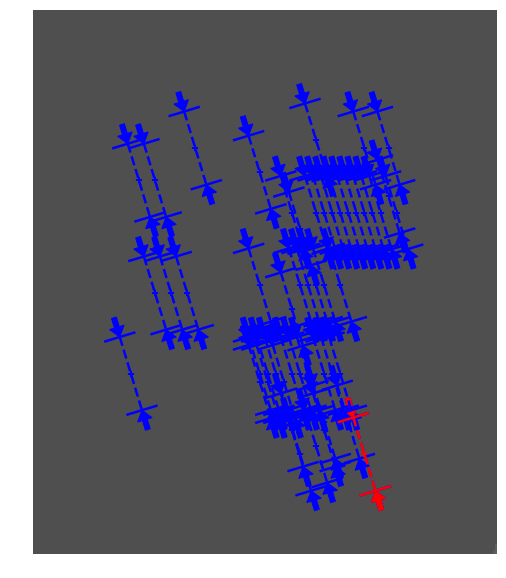

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.6442723834881945, 'left_w1': 0.731520826908636, 'left_w2': -2.997780664186931, 'left_e0': -0.6236138112154298, 'left_e1': 1.8723432453238624, 'left_s0': -0.9227796055944759, 'left_s1': -0.8220672888397197}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.7896057614949804, 'left_w1': 0.5280783564490441, 'left_w2': -3.059000015258789, 'left_e0': -0.42646540371189356, 'left_e1': 1.736722660383046, 'left_s0': -1.0518600293804705, 'left_s1': -0.512993947398979}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.6196210653281543, 'left_w1': 0.7510953163339786, 'left_w2': -2.955512750633573, 'left_e0': -0.6388522761943861, 'left_e1': 1.8585650

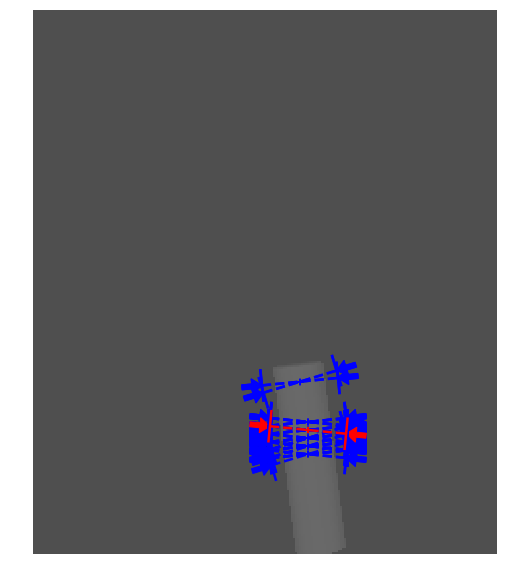

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.5711353587740348, 'left_w1': 0.7158380779514418, 'left_w2': -3.059000015258789, 'left_e0': 0.5642890025321933, 'left_e1': 1.867041736850533, 'left_s0': -1.7016799449920654, 'left_s1': -0.8455312277639053}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.6794340358328312, 'left_w1': 0.49086718703815596, 'left_w2': -3.0208076141802045, 'left_e0': 0.35597989703158345, 'left_e1': 1.7449407728736785, 'left_s0': -1.5730199112913366, 'left_s1': -0.537401890110832}
------------------


[ERROR] [1566356372.951875, 8027.218000]: INVALID POSE - No Valid Joint Solution Found.
[ERROR] [1566356372.952858, 8027.219000]: No Joint Angles provided for move_to_joint_positions. Staying put.


Moving the left arm to ready pose...
Running. Ctrl-c to quit
Moving the left arm to start pose...
Running. Ctrl-c to quit
[INFO] [1566356380.854871, 8035.113000]: 1995: No Contact with Gripper
[0] Total : 0/2, Current : 0
Moving the left arm to start pose...
Running. Ctrl-c to quit
0.996423065662384 0.9986749291419983


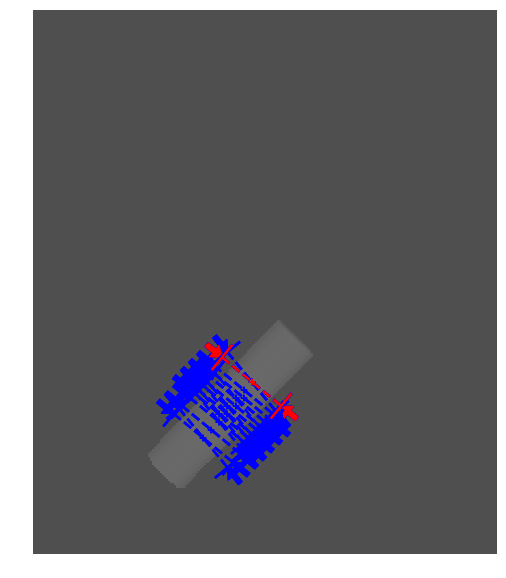

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.20547308529363043, 'left_w1': 0.6580937301938378, 'left_w2': -3.059000015258789, 'left_e0': -0.20575176399026227, 'left_e1': 1.8469735789458686, 'left_s0': -1.0709166229580274, 'left_s1': -0.9137343183138429}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.21664544292543234, 'left_w1': 0.4407232178396887, 'left_w2': -3.059000015258789, 'left_e0': -0.1089175041534579, 'left_e1': 1.7087217977296427, 'left_s0': -1.1420371735517225, 'left_s1': -0.5668997748057069}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.17043953812266432, 'left_w1': 0.6635378812749999, 'left_w2': -3.029637500582545, 'left_e0': -0.17843599747542632, 'left_e1': 1.

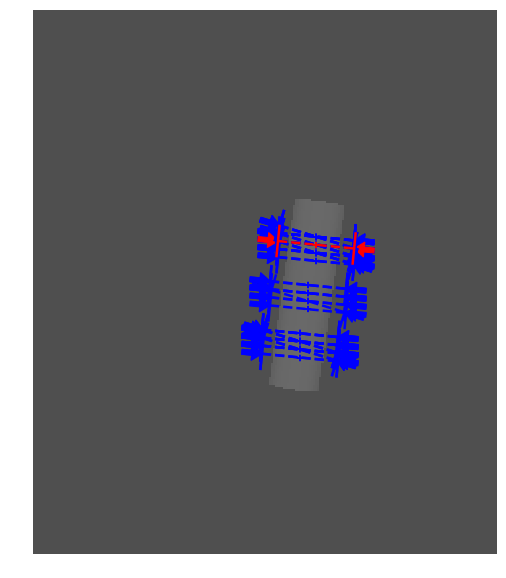

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.6366703421063084, 'left_w1': 0.9493608429909598, 'left_w2': -3.059000015258789, 'left_e0': 0.6429710441107774, 'left_e1': 1.4696995801988337, 'left_s0': -1.6340294848643566, 'left_s1': -0.6331126066984324}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.728591762606322, 'left_w1': 0.7789920149752021, 'left_w2': -3.0509173361159303, 'left_e0': 0.5223623353136145, 'left_e1': 1.3352590544869871, 'left_s0': -1.5543571086289494, 'left_s1': -0.3498787063783468}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.6341190731324645, 'left_w1': 0.9582139933199442, 'left_w2': -3.059000015258789, 'left_e0': 0.6511145922807209, 'left_e1': 1.46987

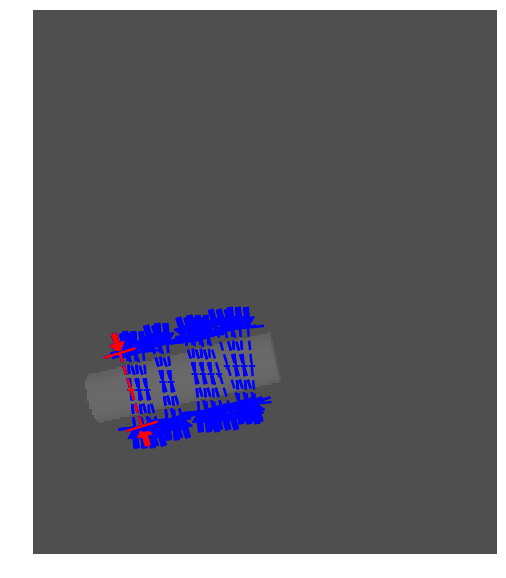

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.6601796337750683, 'left_w1': 0.6977090426458804, 'left_w2': -2.7539772896706065, 'left_e0': -0.6339697949295147, 'left_e1': 1.9413049420370787, 'left_s0': -0.632525829998148, 'left_s1': -0.8502864120693523}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.8465850958867922, 'left_w1': 0.4833292284687909, 'left_w2': -2.8672154736862376, 'left_e0': -0.4192813411709768, 'left_e1': 1.814610193495359, 'left_s0': -0.7756525032791224, 'left_s1': -0.53648000854642}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.6488206794787906, 'left_w1': 0.7184424760264047, 'left_w2': -2.7362813351283912, 'left_e0': -0.6648799251840755, 'left_e1': 1.933940

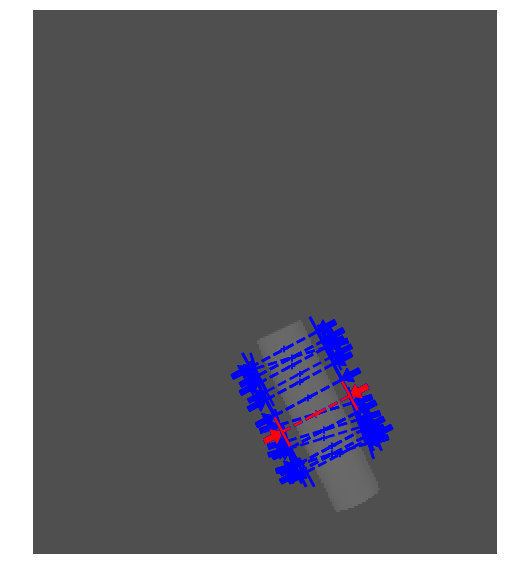

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2795024110922015, 'left_w1': 1.1787778470161976, 'left_w2': 1.2763199021188152, 'left_e0': -1.2281344718495044, 'left_e1': 1.8015136448904596, 'left_s0': -0.48591778980497574, 'left_s1': -0.3581766914021944}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.4628040138312666, 'left_w1': 0.9743268937310975, 'left_w2': 1.2461216422758048, 'left_e0': -0.9818756588686274, 'left_e1': 1.6674493270606434, 'left_s0': -0.5990650403389888, 'left_s1': -0.14240385577355147}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2574361731577355, 'left_w1': 1.1590216449731177, 'left_w2': 1.2887284605624827, 'left_e0': -1.2141453930136936, 'left_e1': 1.783

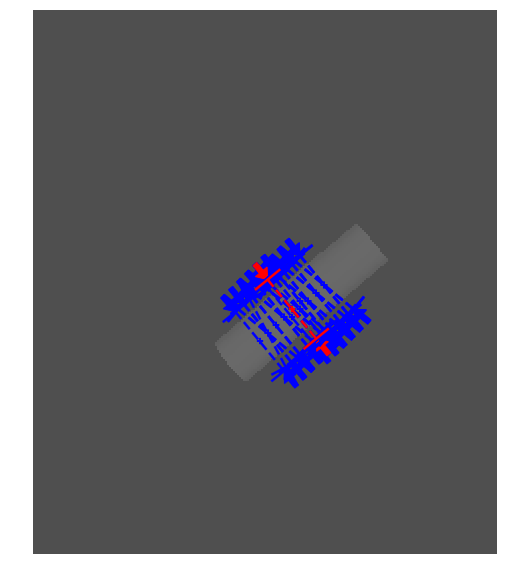

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.4909228479281452, 'left_w1': 0.815609014229821, 'left_w2': -3.059000015258789, 'left_e0': -0.4964032366707122, 'left_e1': 1.6481216626112125, 'left_s0': -0.8848409230644353, 'left_s1': -0.7658909250729229}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.5230692693499607, 'left_w1': 0.6129800976692845, 'left_w2': -3.059000015258789, 'left_e0': -0.32827075833235886, 'left_e1': 1.5164719956946415, 'left_s0': -1.0008504334781427, 'left_s1': -0.4703960405732477}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.43091347238030553, 'left_w1': 0.809980361254481, 'left_w2': -3.016266649099457, 'left_e0': -0.44942689730348456, 'left_e1': 1.6515

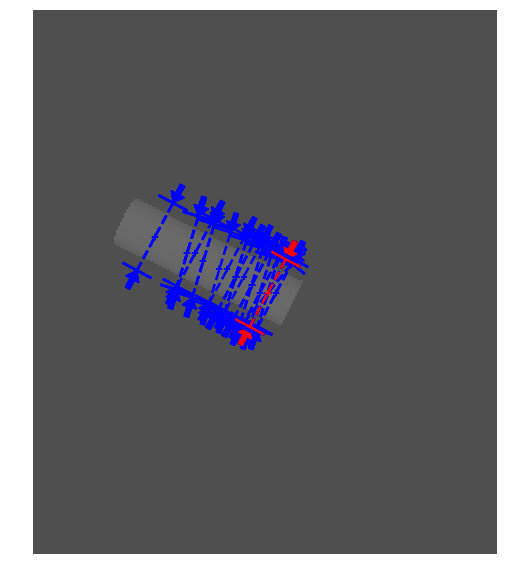

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2078565398210352, 'left_w1': 1.1843645740796271, 'left_w2': 0.9138218967430186, 'left_e0': -1.1680312647992157, 'left_e1': 1.5976241267328681, 'left_s0': -0.480345113537087, 'left_s1': -0.344872594800185}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3513607033739246, 'left_w1': 0.9933708875390185, 'left_w2': 0.904310800469937, 'left_e0': -0.9700375414866149, 'left_e1': 1.4736074172779516, 'left_s0': -0.5743544523586744, 'left_s1': -0.12805881633207572}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.1932132112974572, 'left_w1': 1.1690600143281074, 'left_w2': 0.9184331792442021, 'left_e0': -1.1659928268825006, 'left_e1': 1.5985310

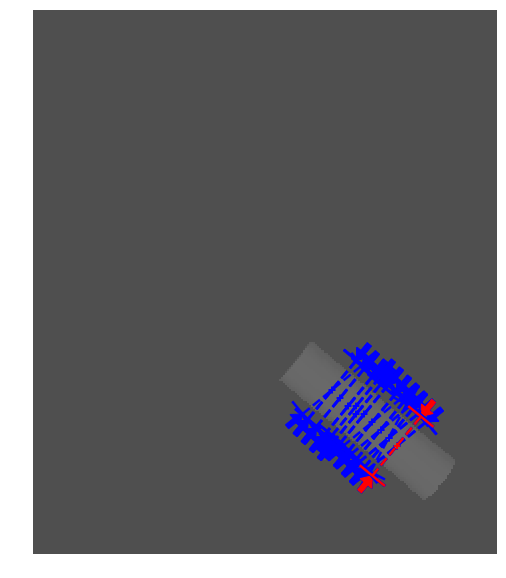

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2290387566840417, 'left_w1': 1.1386858204155947, 'left_w2': 0.8235398474180188, 'left_e0': -1.1752152219657013, 'left_e1': 1.7673707072798939, 'left_s0': -0.6140863386622771, 'left_s1': -0.39728830734334897}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3999949712041087, 'left_w1': 0.9408706441018084, 'left_w2': 0.794374650407319, 'left_e0': -0.9431103950223352, 'left_e1': 1.6367857155475638, 'left_s0': -0.7252780636705773, 'left_s1': -0.17579615696568604}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2001481771165001, 'left_w1': 1.126585497140306, 'left_w2': 0.8405405116779596, 'left_e0': -1.1692748467844467, 'left_e1': 1.75319

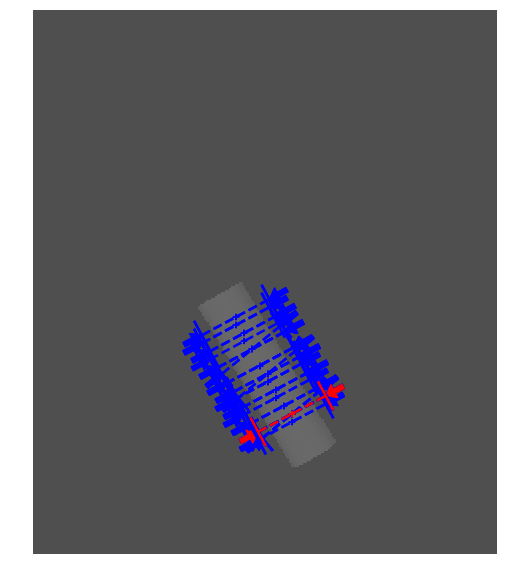

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2793300578692424, 'left_w1': 1.1697784197423036, 'left_w2': 1.2854704028340265, 'left_e0': -1.2275221762404405, 'left_e1': 1.8270831370082319, 'left_s0': -0.454705383465532, 'left_s1': -0.3683356252877562}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.4684437608806429, 'left_w1': 0.9640357240735529, 'left_w2': 1.250650323678276, 'left_e0': -0.9745082040636838, 'left_e1': 1.692637729211314, 'left_s0': -0.5717614490365168, 'left_s1': -0.15212918118390148}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2557203488260729, 'left_w1': 1.148400057580141, 'left_w2': 1.298880012223878, 'left_e0': -1.2116418651076422, 'left_e1': 1.808389073

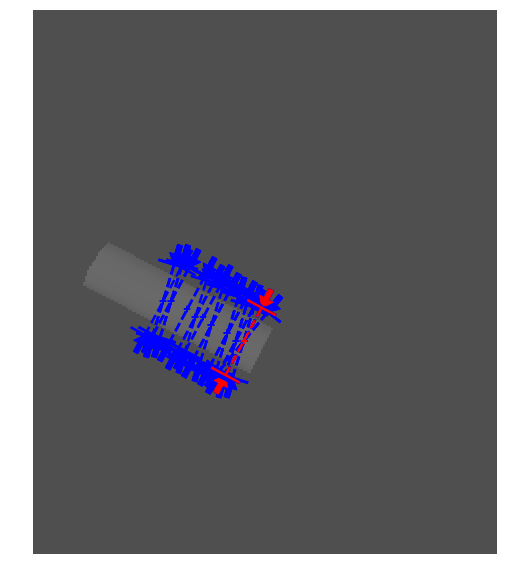

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2079228020485913, 'left_w1': 1.1390604580061527, 'left_w2': 0.851257729253043, 'left_e0': -1.1631846965096497, 'left_e1': 1.7241429546835263, 'left_s0': -0.4374745376475745, 'left_s1': -0.39390534963275003}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.374816888669802, 'left_w1': 0.942983400587959, 'left_w2': 0.8219736974933148, 'left_e0': -0.9384046134194766, 'left_e1': 1.600203061448364, 'left_s0': -0.5460652871474594, 'left_s1': -0.17473411102468817}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.1834453091179526, 'left_w1': 1.131716984263373, 'left_w2': 0.8630695482784998, 'left_e0': -1.1569969149724142, 'left_e1': 1.71673750

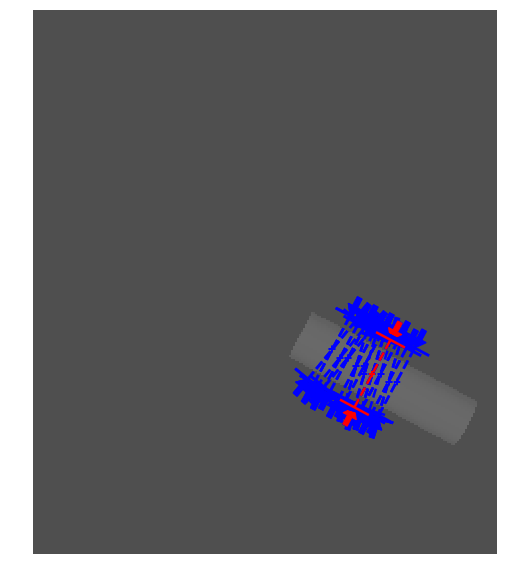

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2044438841173404, 'left_w1': 1.1615819863120584, 'left_w2': 0.7557042484085763, 'left_e0': -1.161432292084445, 'left_e1': 1.6545264657227752, 'left_s0': -0.5942572243506695, 'left_s1': -0.3703872782898796}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3565721078023762, 'left_w1': 0.9688470344839855, 'left_w2': 0.7387313167930919, 'left_e0': -0.9529667190510615, 'left_e1': 1.529230132285843, 'left_s0': -0.6942488619732542, 'left_s1': -0.15121347780375644}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.183048694001664, 'left_w1': 1.1556056535660424, 'left_w2': 0.7656995896466252, 'left_e0': -1.1589256684845861, 'left_e1': 1.6490213

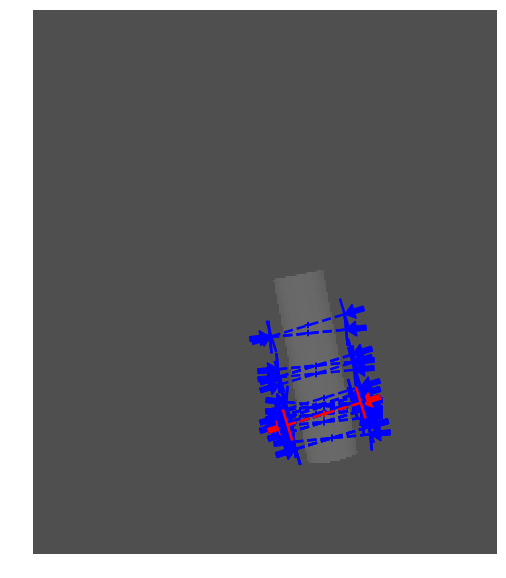

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3017296037262227, 'left_w1': 1.2062237292975075, 'left_w2': 1.4647232482283172, 'left_e0': -1.2522815890810353, 'left_e1': 1.7946219680664555, 'left_s0': -0.48481773798553085, 'left_s1': -0.3314386679947363}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.4851954026165515, 'left_w1': 0.9994832405507474, 'left_w2': 1.438993731562327, 'left_e0': -1.0057064090332766, 'left_e1': 1.6571895384668676, 'left_s0': -0.5956242714695774, 'left_s1': -0.11752530805043243}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.282104018208459, 'left_w1': 1.1861411322123099, 'left_w2': 1.4747157401853852, 'left_e0': -1.235866716146941, 'left_e1': 1.774191

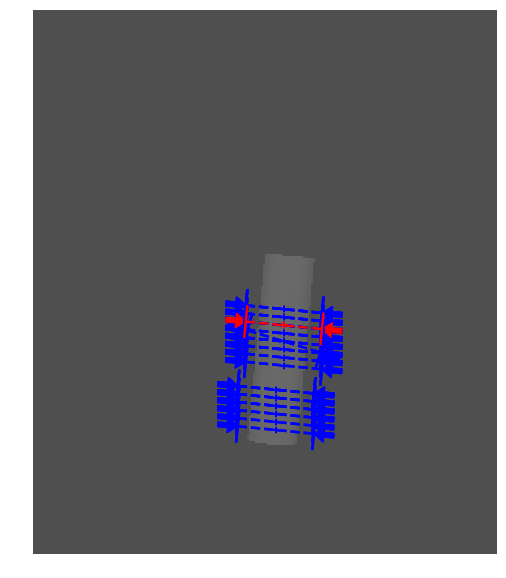

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.5510370232592583, 'left_w1': 0.81049623519105, 'left_w2': -3.059000015258789, 'left_e0': 0.5541677253110758, 'left_e1': 1.6867811714997998, 'left_s0': -1.6165307230396526, 'left_s1': -0.7656092958940276}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.6532232430064304, 'left_w1': 0.6162108575403814, 'left_w2': -3.0245454572161297, 'left_e0': 0.40533193882913554, 'left_e1': 1.5588223561246597, 'left_s0': -1.515704374121387, 'left_s1': -0.4649220038275878}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.549575922104314, 'left_w1': 0.8203516072358047, 'left_w2': -3.059000015258789, 'left_e0': 0.5670664223499629, 'left_e1': 1.6861081

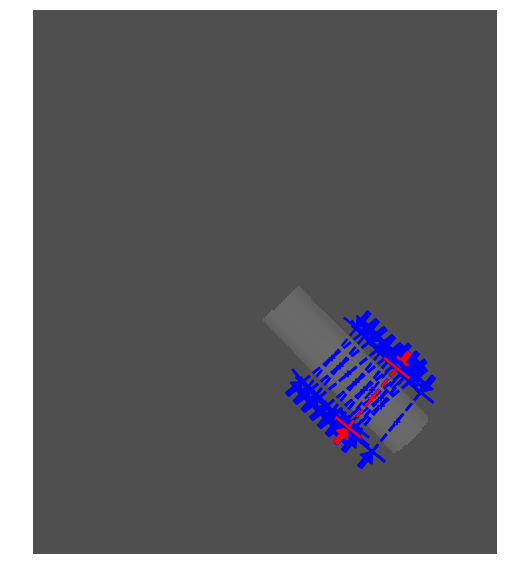

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.230680017512834, 'left_w1': 1.165828971485998, 'left_w2': 0.9061057721582856, 'left_e0': -1.183225721079491, 'left_e1': 1.7031538382637217, 'left_s0': -0.5815021408276154, 'left_s1': -0.36677881327542083}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3920606299868545, 'left_w1': 0.9697552616566533, 'left_w2': 0.8851390384321005, 'left_e0': -0.9634780054523542, 'left_e1': 1.575496461207134, 'left_s0': -0.6851087569061081, 'left_s1': -0.14890393951480285}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.206588939474146, 'left_w1': 1.1592671725999362, 'left_w2': 0.9177777284756713, 'left_e0': -1.1782367744905715, 'left_e1': 1.69314556

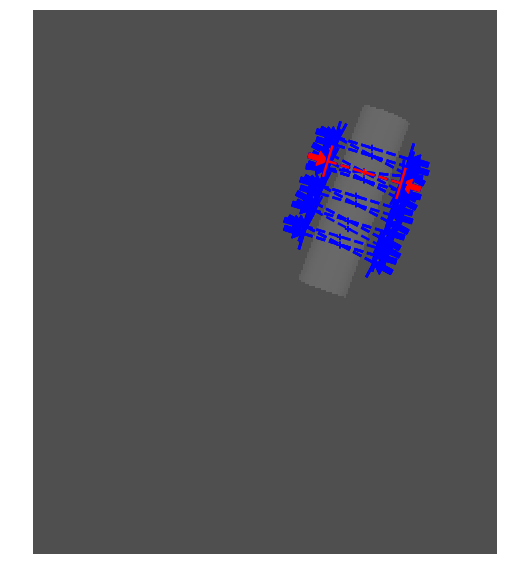

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.40829278211565007, 'left_w1': 1.0110742907346908, 'left_w2': -3.059000015258789, 'left_e0': 0.41855323318687676, 'left_e1': 1.237185304571679, 'left_s0': -1.4774665045989037, 'left_s1': -0.5955983458468923}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.4711265748060104, 'left_w1': 0.869081397775567, 'left_w2': -3.059000015258789, 'left_e0': 0.3707009090141955, 'left_e1': 1.0738187270715, 'left_s0': -1.4368991948468135, 'left_s1': -0.294686384302273}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.42255099805567486, 'left_w1': 1.018250034389323, 'left_w2': -3.0524871166764562, 'left_e0': 0.43510562245851087, 'left_e1': 1.2397446

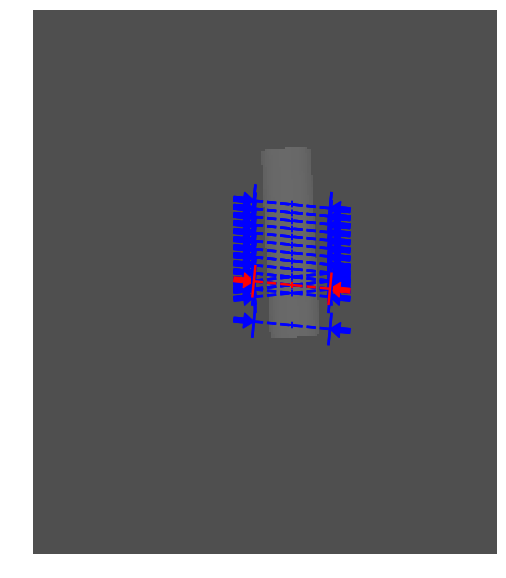

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.5739555108372743, 'left_w1': 0.8682215404460004, 'left_w2': -3.059000015258789, 'left_e0': 0.5794781472596562, 'left_e1': 1.590864244782995, 'left_s0': -1.610205935263328, 'left_s1': -0.7125011298489895}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.6721102785482158, 'left_w1': 0.6860011347375967, 'left_w2': -3.034673955295294, 'left_e0': 0.44783863517782246, 'left_e1': 1.4606824741265763, 'left_s0': -1.522406587825322, 'left_s1': -0.41891471697956123}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.5729174364486123, 'left_w1': 0.8778719477208669, 'left_w2': -3.059000015258789, 'left_e0': 0.5900385868008144, 'left_e1': 1.590612

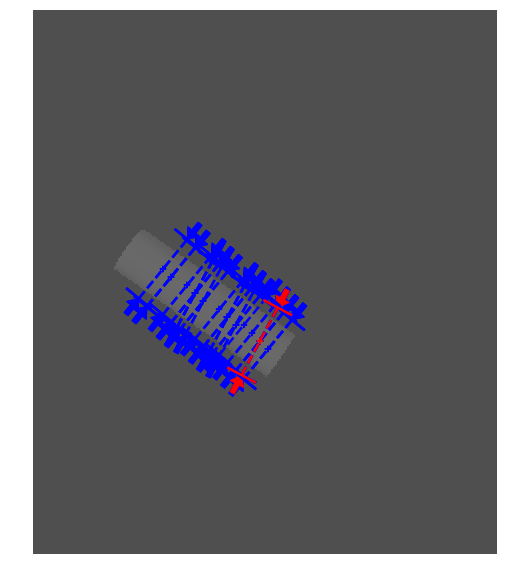

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2077520242539928, 'left_w1': 1.1444911459143698, 'left_w2': 0.843770846377363, 'left_e0': -1.163532969680853, 'left_e1': 1.7091335178525249, 'left_s0': -0.45748736545046026, 'left_s1': -0.3880907509499245}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3715896582626392, 'left_w1': 0.9491091946248454, 'left_w2': 0.8170817466434301, 'left_e0': -0.9422064848800163, 'left_e1': 1.5852748957286915, 'left_s0': -0.5640720858586092, 'left_s1': -0.16914812848802532}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.185588722533828, 'left_w1': 1.1357335114314273, 'left_w2': 0.8545979687402973, 'left_e0': -1.1579508317150398, 'left_e1': 1.702868

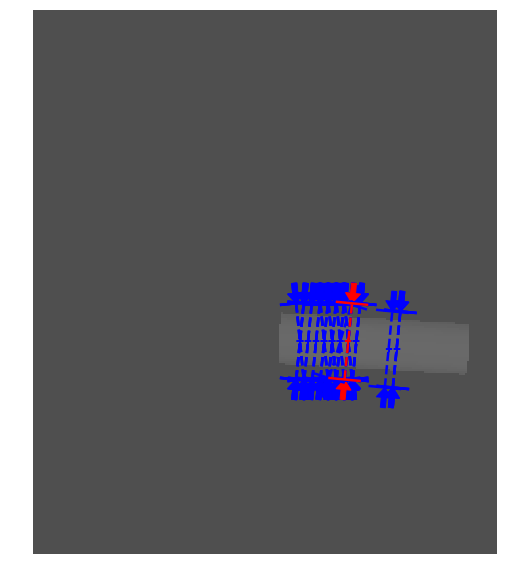

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.1488165085589224, 'left_w1': 1.1332107657011345, 'left_w2': 0.4370705598588255, 'left_e0': -1.1126791974701162, 'left_e1': 1.6177875939227433, 'left_s0': -0.5908905226998451, 'left_s1': -0.4016671885150206}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2930819099454902, 'left_w1': 0.9444658596349841, 'left_w2': 0.4198152026825666, 'left_e0': -0.9140359352047291, 'left_e1': 1.4949237849936456, 'left_s0': -0.6906347671613035, 'left_s1': -0.1770390338233001}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.127732953011006, 'left_w1': 1.1317664037805533, 'left_w2': 0.4470333837827815, 'left_e0': -1.1112845234710016, 'left_e1': 1.615403

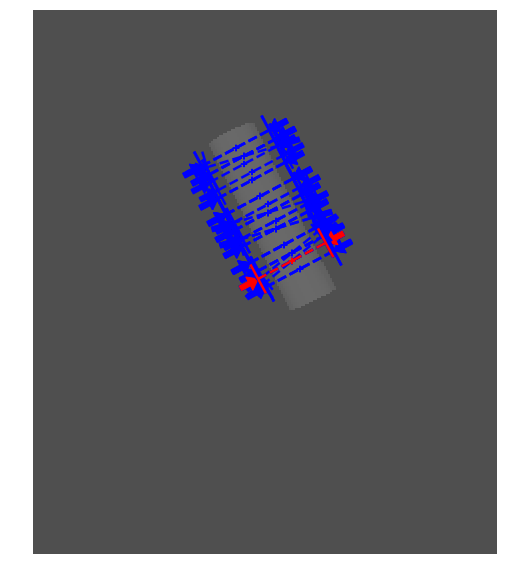

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2947242731766764, 'left_w1': 1.2788493640179912, 'left_w2': 1.5256058599416693, 'left_e0': -1.250615481200624, 'left_e1': 1.4990245384381065, 'left_s0': -0.49361666272017596, 'left_s1': -0.23877994368588681}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.4257733059326294, 'left_w1': 1.0858393594370122, 'left_w2': 1.5351334146630227, 'left_e0': -1.0676820618895473, 'left_e1': 1.3708256111563357, 'left_s0': -0.5743533347018032, 'left_s1': -0.032009708094834326}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2824252810529535, 'left_w1': 1.2780202861264096, 'left_w2': 1.525715449934852, 'left_e0': -1.2485672370303944, 'left_e1': 1.498

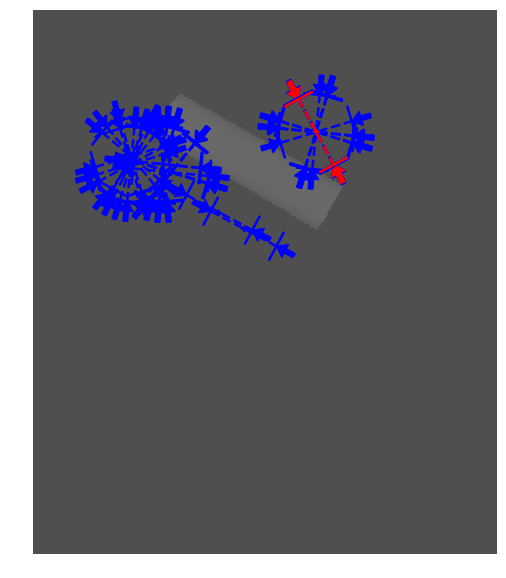

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.4955916240526866, 'left_w1': 1.0647336842864397, 'left_w2': -2.7114626400405553, 'left_e0': -0.5132115975957052, 'left_e1': 1.1697459089090796, 'left_s0': -0.8965921507245989, 'left_s1': -0.5442637146890705}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.5452157712701722, 'left_w1': 0.922897093750054, 'left_w2': -2.696149453076808, 'left_e0': -0.441813210090186, 'left_e1': 0.9989999613669771, 'left_s0': -0.9524684898501113, 'left_s1': -0.2486357530516416}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.4928785933690041, 'left_w1': 1.0486803062780068, 'left_w2': -2.7135973504156072, 'left_e0': -0.5136382266731424, 'left_e1': 1.17876

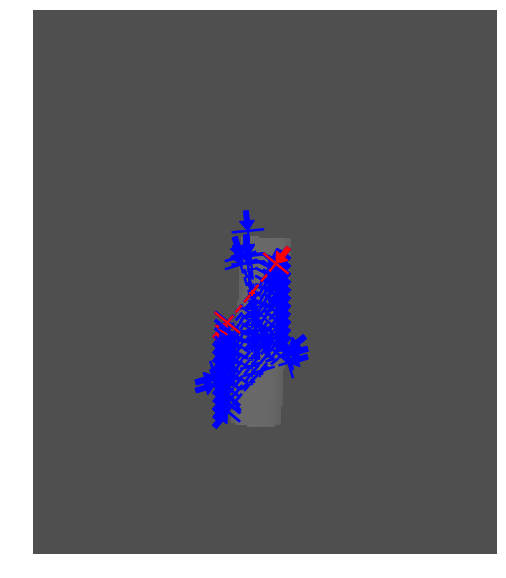

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2356252438780557, 'left_w1': 1.2013093753752595, 'left_w2': 1.109550440191571, 'left_e0': -1.1934471152335036, 'left_e1': 1.6127281131581201, 'left_s0': -0.44975896204813176, 'left_s1': -0.32627044880835304}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3831678863681756, 'left_w1': 1.0080396939292164, 'left_w2': 1.1002032546575111, 'left_e0': -0.9910165726413442, 'left_e1': 1.4877731398278298, 'left_s0': -0.5434399010078288, 'left_s1': -0.11238174965480009}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.213292777117524, 'left_w1': 1.2008758447148873, 'left_w2': 1.1163119404971131, 'left_e0': -1.2027507355146747, 'left_e1': 1.6031

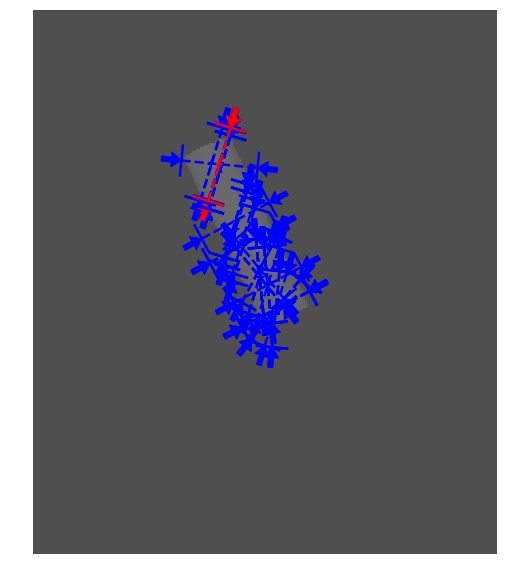

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.178449196428509, 'left_w1': 1.2466974065994378, 'left_w2': 0.9443850910239124, 'left_e0': -1.1489101389601777, 'left_e1': 1.3375393384929395, 'left_s0': -0.4946387716200451, 'left_s1': -0.28108536370835446}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2789317574335015, 'left_w1': 1.0672030804114967, 'left_w2': 0.9696308501766129, 'left_e0': -0.9983443825631462, 'left_e1': 1.200865163264639, 'left_s0': -0.5734708028410161, 'left_s1': -0.05973667044555619}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.1659675906285305, 'left_w1': 1.2486871215213708, 'left_w2': 0.947127998817709, 'left_e0': -1.1497571790627859, 'left_e1': 1.341085

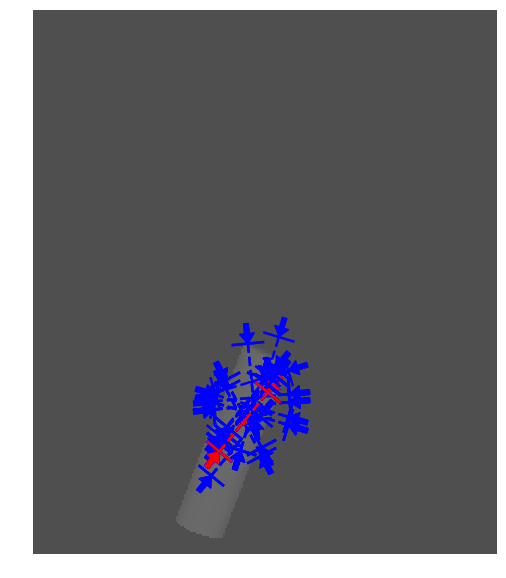

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.234729914575018, 'left_w1': 1.0957860743723558, 'left_w2': 0.9163506148571616, 'left_e0': -1.1773756147411296, 'left_e1': 1.8871083844115768, 'left_s0': -0.41678590170055896, 'left_s1': -0.4421536807749823}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.4358026824338044, 'left_w1': 0.8911665643741388, 'left_w2': 0.8609507788329074, 'left_e0': -0.9118695968567672, 'left_e1': 1.7577627508896068, 'left_s0': -0.5481415510243594, 'left_s1': -0.22035288797175154}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.1996251350986282, 'left_w1': 1.0770872071130515, 'left_w2': 0.9368613822082033, 'left_e0': -1.160066574545063, 'left_e1': 1.87019

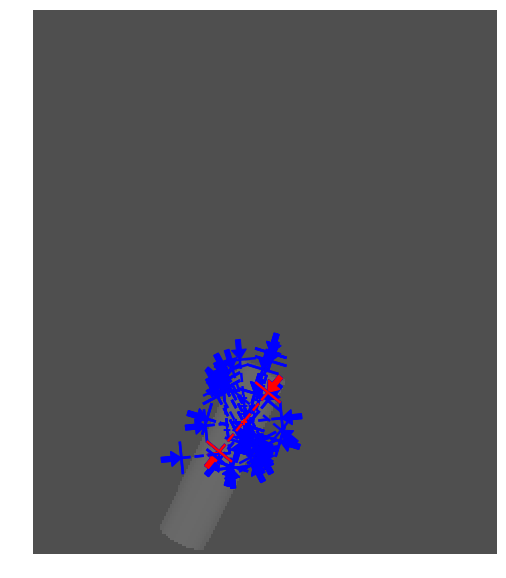

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2347062894021281, 'left_w1': 1.0957633230840718, 'left_w2': 0.9163577194493404, 'left_e0': -1.1773550969904187, 'left_e1': 1.887112620145217, 'left_s0': -0.4167952963206815, 'left_s1': -0.44217972165534936}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.4357847223999807, 'left_w1': 0.8911499460152961, 'left_w2': 0.8609544914864466, 'left_e0': -0.9118544545522366, 'left_e1': 1.7577624629948305, 'left_s0': -0.5481526451662626, 'left_s1': -0.22036724502323074}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.1969611120173427, 'left_w1': 1.0761268325521578, 'left_w2': 0.9378845684785957, 'left_e0': -1.1622306799142197, 'left_e1': 1.8705

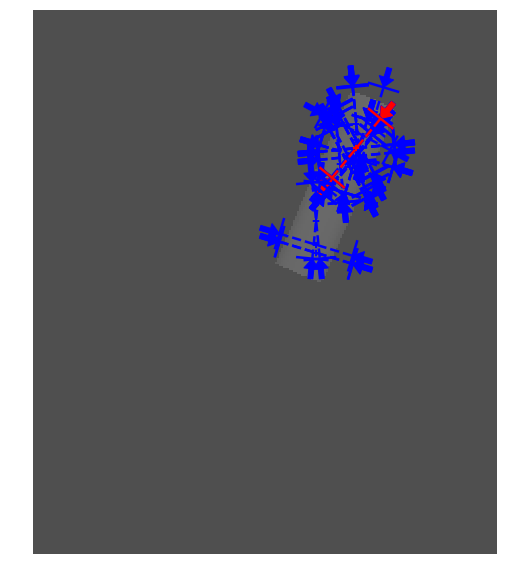

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2424830859495326, 'left_w1': 1.3304643458074128, 'left_w2': 1.314827736650962, 'left_e0': -1.2118870907663073, 'left_e1': 1.146825714041214, 'left_s0': -0.6560397183836836, 'left_s1': -0.18742690554188224}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.317165249990104, 'left_w1': 1.1541606645583586, 'left_w2': 1.372706644173955, 'left_e0': -1.0883998687345018, 'left_e1': 0.9832019177383351, 'left_s0': -0.7330378162037559, 'left_s1': 0.034132200544756144}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2326104251145116, 'left_w1': 1.3342859350134402, 'left_w2': 1.3174558983730205, 'left_e0': -1.2127330460815369, 'left_e1': 1.1485285

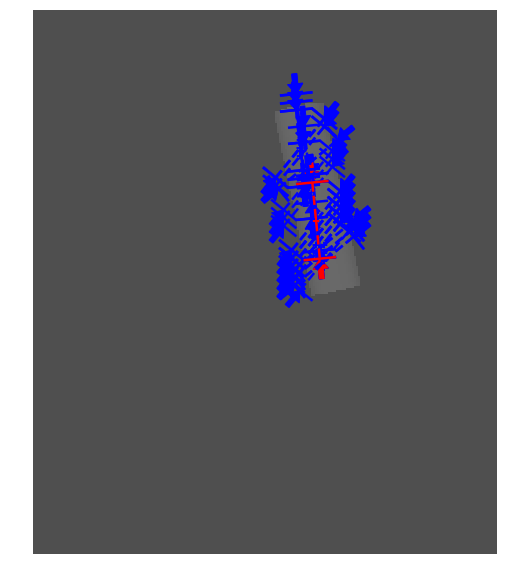

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.5918969849658883, 'left_w1': 0.9635753386563145, 'left_w2': -2.4699801012988694, 'left_e0': -0.6015165808742653, 'left_e1': 1.4169451135065574, 'left_s0': -0.8377990343889223, 'left_s1': -0.6255118954410124}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.6738434111738751, 'left_w1': 0.7989664300410204, 'left_w2': -2.4798877564550716, 'left_e0': -0.49503087292591297, 'left_e1': 1.2751303961617309, 'left_s0': -0.910195829510634, 'left_s1': -0.3380537467613431}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.5857600765431781, 'left_w1': 0.9701580783388557, 'left_w2': -2.4643125894501376, 'left_e0': -0.6063935935847582, 'left_e1': 1.41

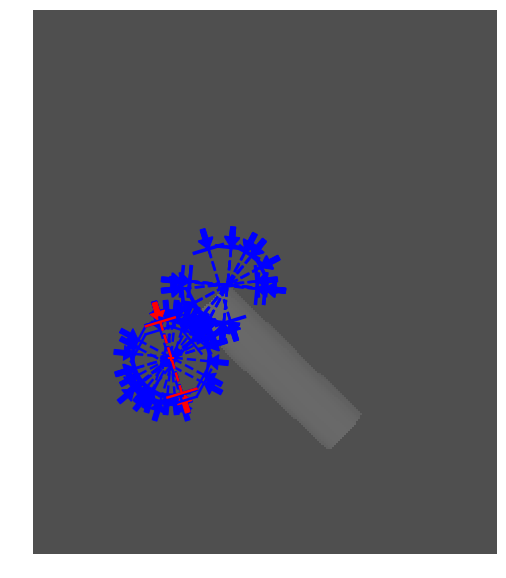

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.6414804850502345, 'left_w1': 0.7363771833755088, 'left_w2': -2.740711841855184, 'left_e0': -0.6254125319193423, 'left_e1': 1.8655910523594792, 'left_s0': -0.6698186700907753, 'left_s1': -0.8195941842833012}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.8050201723060587, 'left_w1': 0.5320693532234261, 'left_w2': -2.8321310708489236, 'left_e0': -0.4345988343432054, 'left_e1': 1.7377615142134468, 'left_s0': -0.7969281997826364, 'left_s1': -0.5105298186882938}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.6317562588097149, 'left_w1': 0.7544393890450456, 'left_w2': -2.7263334777364774, 'left_e0': -0.6487420906155225, 'left_e1': 1.859

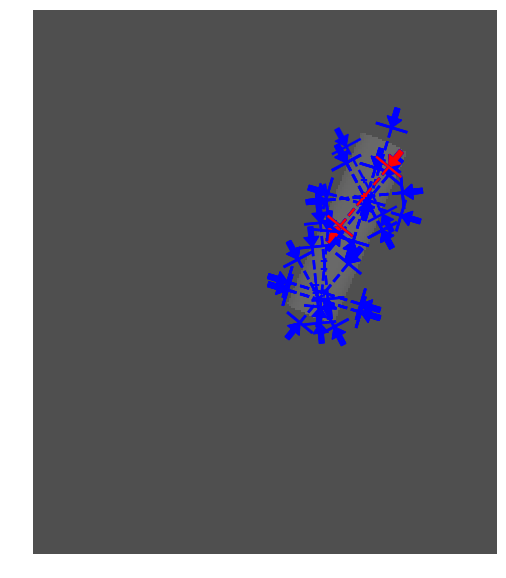

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2407361241058232, 'left_w1': 1.3016346420519873, 'left_w2': 1.2311330047688585, 'left_e0': -1.2070449669164, 'left_e1': 1.2630506801775612, 'left_s0': -0.6346441441015509, 'left_s1': -0.21666769297811522}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.332619874722654, 'left_w1': 1.1207743784311257, 'left_w2': 1.269627136861444, 'left_e0': -1.0658544716194298, 'left_e1': 1.1191519491955655, 'left_s0': -0.7095962644865105, 'left_s1': -0.0005765212522809843}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2387967467816985, 'left_w1': 1.3036451544355632, 'left_w2': 1.2311798319942753, 'left_e0': -1.2039694064126332, 'left_e1': 1.264897

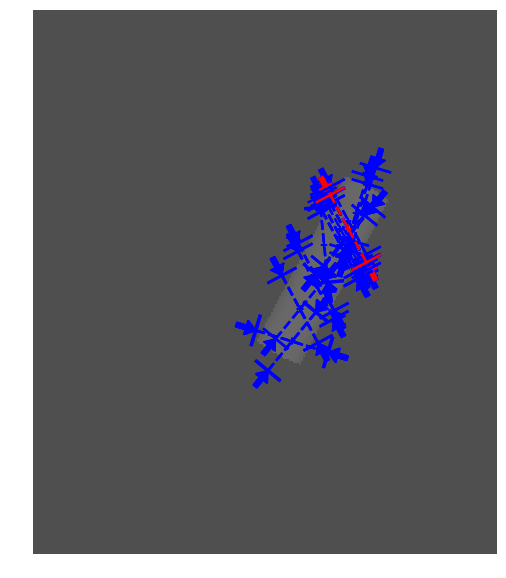

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.5263676190584587, 'left_w1': 0.952961787128728, 'left_w2': -2.851346537763076, 'left_e0': -0.5383420922915678, 'left_e1': 1.4058237080427183, 'left_s0': -0.906621660130458, 'left_s1': -0.6427940404043742}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.6007353472167651, 'left_w1': 0.7908308124703465, 'left_w2': -2.859645847028769, 'left_e0': -0.4429410687659174, 'left_e1': 1.2583184591785492, 'left_s0': -0.9731677847731689, 'left_s1': -0.34813973741033316}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.5131409361618842, 'left_w1': 0.9551709320875444, 'left_w2': -2.8471485872513376, 'left_e0': -0.5491712530661446, 'left_e1': 1.40085

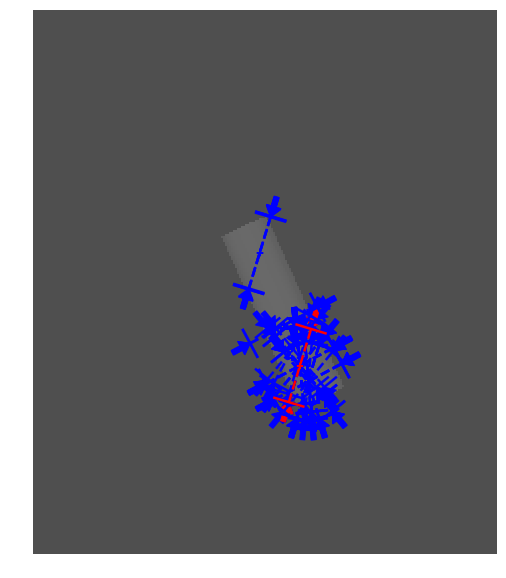

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.1803154220345613, 'left_w1': 1.1170034314728297, 'left_w2': 0.6027317636081931, 'left_e0': -1.1365499359382798, 'left_e1': 1.7192400180864236, 'left_s0': -0.5156603975688513, 'left_s1': -0.41737902966343926}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3445614922435853, 'left_w1': 0.9227835924579667, 'left_w2': 0.5714437650870382, 'left_e0': -0.9148141250339046, 'left_e1': 1.596505332502164, 'left_s0': -0.6255030735619111, 'left_s1': -0.19454881850200878}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.1545709872339533, 'left_w1': 1.110997058132142, 'left_w2': 0.6159045179521401, 'left_e0': -1.1315948316970548, 'left_e1': 1.71302

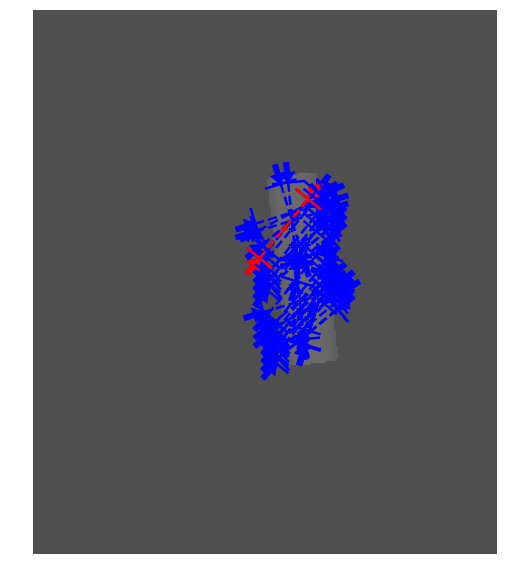

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2392977397847282, 'left_w1': 1.25648925702383, 'left_w2': 1.1976039311262638, 'left_e0': -1.201082134767238, 'left_e1': 1.4329399531168932, 'left_s0': -0.5167478444092779, 'left_s1': -0.26488489431946616}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3568865870487945, 'left_w1': 1.0697342139291346, 'left_w2': 1.2125839255518223, 'left_e0': -1.0323107385096606, 'left_e1': 1.3037178620457752, 'left_s0': -0.5964932961499019, 'left_s1': -0.05210704171570729}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2293688102017697, 'left_w1': 1.243613787945728, 'left_w2': 1.1967885004168524, 'left_e0': -1.19873802204161, 'left_e1': 1.438303862

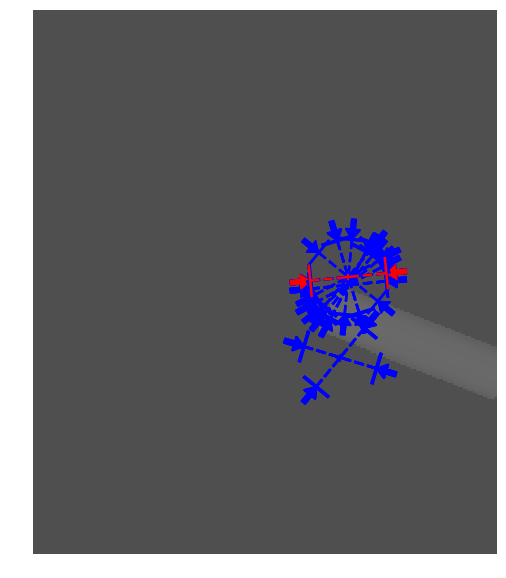

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3498103838470807, 'left_w1': 1.3262952580981908, 'left_w2': 1.8675852217545976, 'left_e0': -1.3026585433684335, 'left_e1': 1.4756568127571612, 'left_s0': -0.5415504103391128, 'left_s1': -0.1847375848061275}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.4802367944562524, 'left_w1': 1.1296949527715436, 'left_w2': 1.8827303039634877, 'left_e0': -1.1218009753278428, 'left_e1': 1.3441141597850892, 'left_s0': -0.6184415563528856, 'left_s1': 0.01690870981775553}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.4735466575094347, 'left_w1': 1.3194802913267714, 'left_w2': 1.8395811585550763, 'left_e0': -1.2983033722057646, 'left_e1': 1.51414

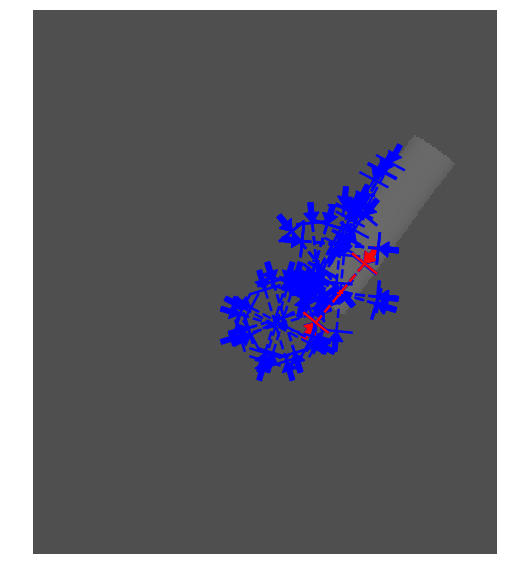

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2357757721736289, 'left_w1': 1.2295658909010687, 'left_w2': 1.0790973831605524, 'left_e0': -1.1958894566827434, 'left_e1': 1.5205883452914823, 'left_s0': -0.5602115226436666, 'left_s1': -0.29497139873274497}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3673351324759264, 'left_w1': 1.0397375932481843, 'left_w2': 1.0824967363627176, 'left_e0': -1.0114698898151016, 'left_e1': 1.3941133290316137, 'left_s0': -0.6458900235192176, 'left_s1': -0.08182093515148986}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2209989823394065, 'left_w1': 1.2280274878123885, 'left_w2': 1.0825837887925631, 'left_e0': -1.194495435994592, 'left_e1': 1.5202

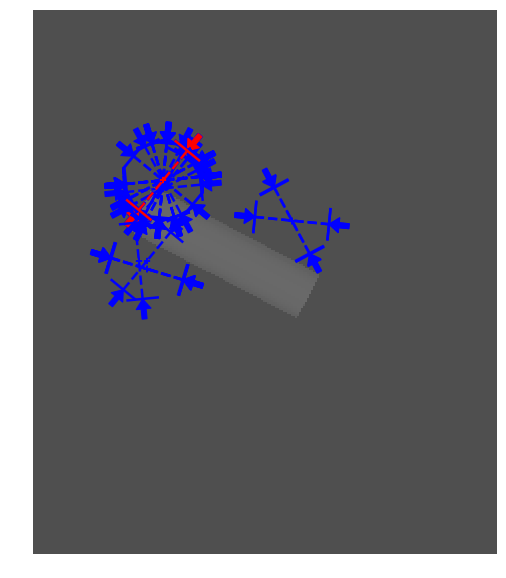

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2387270714498928, 'left_w1': 1.2603336430796401, 'left_w2': 1.3330059023941359, 'left_e0': -1.2011542004001539, 'left_e1': 1.419350271699926, 'left_s0': -0.3939442362965841, 'left_s1': -0.26122543312899094}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3541032876199792, 'left_w1': 1.0739996674674972, 'left_w2': 1.3502828881485884, 'left_e0': -1.0348341461595234, 'left_e1': 1.2882087973265255, 'left_s0': -0.47330361871431087, 'left_s1': -0.047902093267331844}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2262695685600906, 'left_w1': 1.2610160870607785, 'left_w2': 1.3348974246791652, 'left_e0': -1.2014126648997487, 'left_e1': 1.42

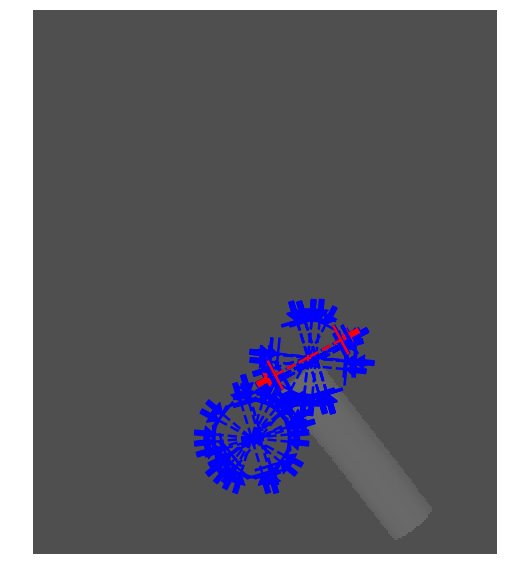

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2834849674990425, 'left_w1': 1.2143649217067891, 'left_w2': 1.3612507033175327, 'left_e0': -1.2364877195414343, 'left_e1': 1.7067215436969831, 'left_s0': -0.47945762304212924, 'left_s1': -0.3160985560845941}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.4500416887164955, 'left_w1': 1.0136331134377006, 'left_w2': 1.3442369441787163, 'left_e0': -1.0115241854047972, 'left_e1': 1.5763352296326216, 'left_s0': -0.5801846801358244, 'left_s1': -0.1044527113790303}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2649404943989058, 'left_w1': 1.2043776071416985, 'left_w2': 1.3681660711286325, 'left_e0': -1.2273167030767385, 'left_e1': 1.6946

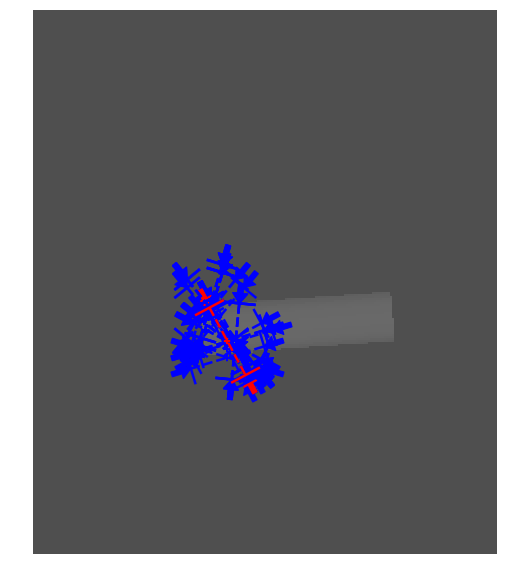

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.5922183928177925, 'left_w1': 0.770442025836753, 'left_w2': -2.9306421612061406, 'left_e0': -0.5857020894959024, 'left_e1': 1.7788109945721957, 'left_s0': -0.7622539139037496, 'left_s1': -0.795440005918763}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.7287660706208534, 'left_w1': 0.5769999481888615, 'left_w2': -2.998704967107268, 'left_e0': -0.42544982155703537, 'left_e1': 1.6459454295141658, 'left_s0': -0.8700871447287587, 'left_s1': -0.4865837190796896}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.5851516301914784, 'left_w1': 0.7873890447959474, 'left_w2': -2.9197950433567206, 'left_e0': -0.6043265651047248, 'left_e1': 1.7711

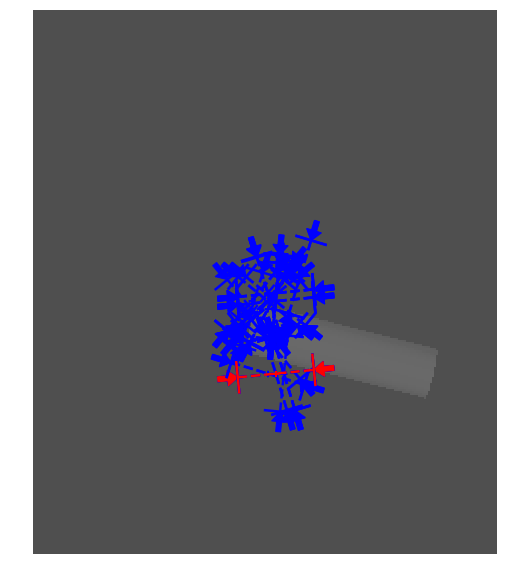

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3377128316629494, 'left_w1': 1.226967655980041, 'left_w2': 1.727931186154272, 'left_e0': -1.2628277276766418, 'left_e1': 1.7570408333900267, 'left_s0': -0.4284533707250918, 'left_s1': -0.28005339618814895}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.5123843732484248, 'left_w1': 1.0316975783713964, 'left_w2': 1.709104546657726, 'left_e0': -1.035565417625798, 'left_e1': 1.640394325086983, 'left_s0': -0.5188062441883493, 'left_s1': -0.08507357936883361}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3124609897141506, 'left_w1': 1.2232179483729415, 'left_w2': 1.7359781388836673, 'left_e0': -1.2624119718598037, 'left_e1': 1.75721189

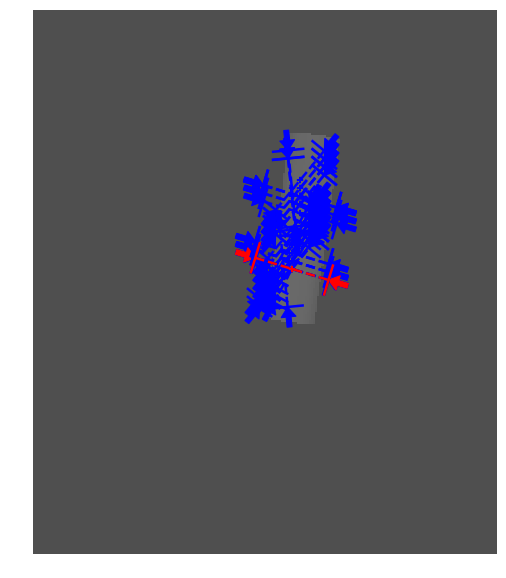

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.2847535320193186, 'left_w1': 0.8192825362668216, 'left_w2': -3.059000015258789, 'left_e0': 0.29153197571233025, 'left_e1': 1.5689991123510387, 'left_s0': -1.410749128606891, 'left_s1': -0.7754080231696215}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.34302870334973196, 'left_w1': 0.6400899551228584, 'left_w2': -3.045328815914676, 'left_e0': 0.22699807792632287, 'left_e1': 1.430080572842157, 'left_s0': -1.3652857288702167, 'left_s1': -0.4602295928277678}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': -0.2854012795467856, 'left_w1': 0.8270775689956572, 'left_w2': -3.059000015258789, 'left_e0': 0.30011898852536445, 'left_e1': 1.571

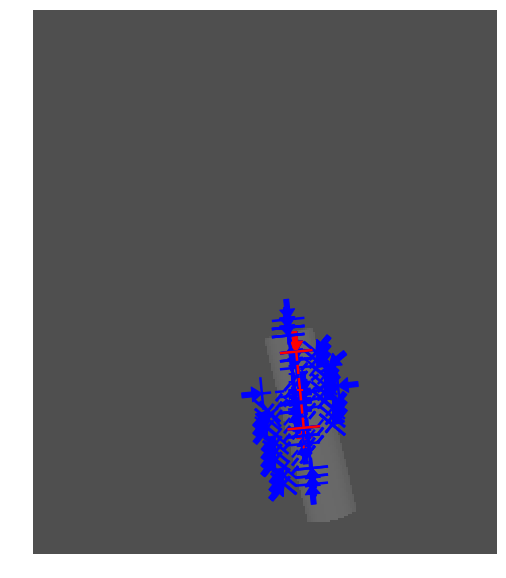

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.6555755061847269, 'left_w1': 0.7789024722822453, 'left_w2': -2.682729445762894, 'left_e0': -0.6447773177209631, 'left_e1': 1.800348471472244, 'left_s0': -0.8110107197266362, 'left_s1': -0.7822794435146598}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.8057640086137791, 'left_w1': 0.5828517546134693, 'left_w2': -2.757581074494792, 'left_e0': -0.46609403660020127, 'left_e1': 1.6716435669143554, 'left_s0': -0.9285159334197117, 'left_s1': -0.4803056814867437}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.6444077982181589, 'left_w1': 0.7947896366643545, 'left_w2': -2.66793241712184, 'left_e0': -0.6629141522662263, 'left_e1': 1.793990

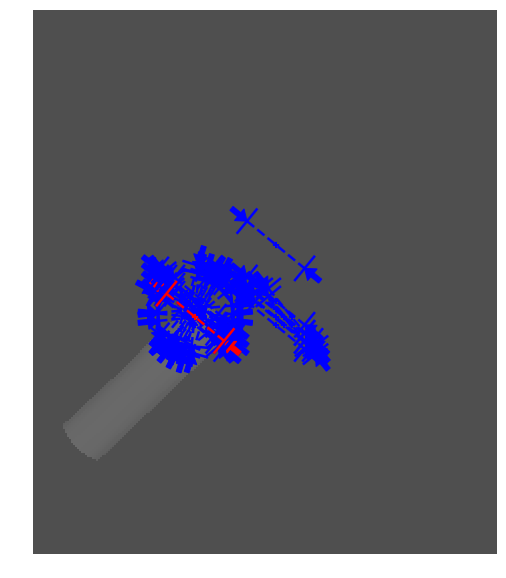

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.3180808050849565, 'left_w1': 0.7197259300895221, 'left_w2': -3.059000015258789, 'left_e0': -0.3210115046872128, 'left_e1': 1.7610789147284613, 'left_s0': -0.9094330085490386, 'left_s1': -0.8587739498856232}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.3372290158872593, 'left_w1': 0.5097653272107144, 'left_w2': -3.059000015258789, 'left_e0': -0.18852330710961476, 'left_e1': 1.625726710359434, 'left_s0': -1.00463230390337, 'left_s1': -0.5325356473925876}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.2697963240199547, 'left_w1': 0.7214165134726886, 'left_w2': -3.0207253500282536, 'left_e0': -0.28339881288736646, 'left_e1': 1.76336

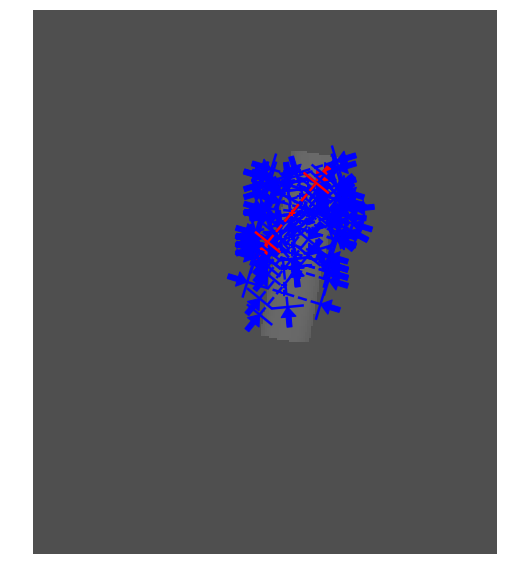

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.240204840163838, 'left_w1': 1.269757924582098, 'left_w2': 1.2208430937465584, 'left_e0': -1.2030468340667002, 'left_e1': 1.3856355455360152, 'left_s0': -0.535100869811284, 'left_s1': -0.25039258449237}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.350400915444367, 'left_w1': 1.0846248006168029, 'left_w2': 1.2421679648994204, 'left_e0': -1.0422835905298098, 'left_e1': 1.2536246717090775, 'left_s0': -0.612615285112139, 'left_s1': -0.03721054562269162}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.231022328053237, 'left_w1': 1.2652679015217643, 'left_w2': 1.2208455027524903, 'left_e0': -1.2045768546887665, 'left_e1': 1.391546857775

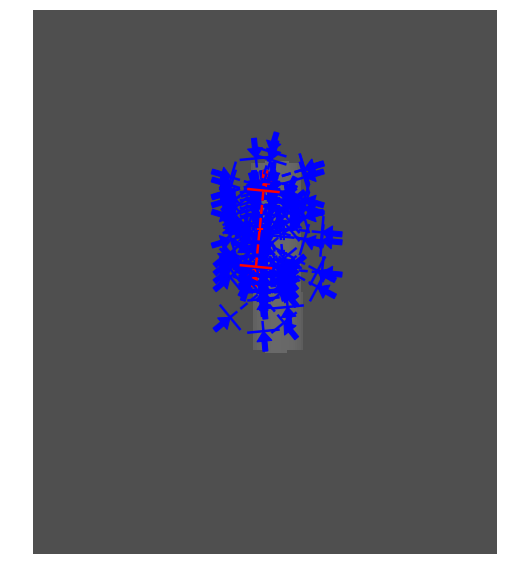

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.14817901115827, 'left_w1': 1.1895118592545706, 'left_w2': 0.6398803648216136, 'left_e0': -1.1180985306159794, 'left_e1': 1.4608715402931962, 'left_s0': -0.5166199966202693, 'left_s1': -0.34313885999846283}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.266472638207479, 'left_w1': 1.0069354583222352, 'left_w2': 0.6458535178396595, 'left_e0': -0.9484735748470277, 'left_e1': 1.3332117715898844, 'left_s0': -0.6027403322028932, 'left_s1': -0.11979683605653425}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.1378822215266897, 'left_w1': 1.176175320265292, 'left_w2': 0.6421428684029842, 'left_e0': -1.1161299993393607, 'left_e1': 1.4660833

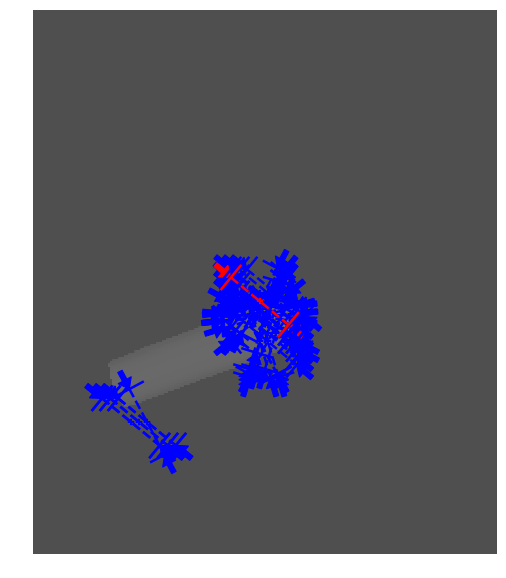

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.2652721960029186, 'left_w1': 0.7565462860051879, 'left_w2': -3.059000015258789, 'left_e0': -0.2699854545723267, 'left_e1': 1.6805529928519978, 'left_s0': -1.003291476178264, 'left_s1': -0.8302161520535581}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.28309771876102613, 'left_w1': 0.559720601535707, 'left_w2': -3.059000015258789, 'left_e0': -0.17048516443092582, 'left_e1': 1.542496516875192, 'left_s0': -1.0741292391151642, 'left_s1': -0.507092218166975}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.23053372853248688, 'left_w1': 0.759931917498945, 'left_w2': -3.0322345427073674, 'left_e0': -0.2422140791614927, 'left_e1': 1.682582

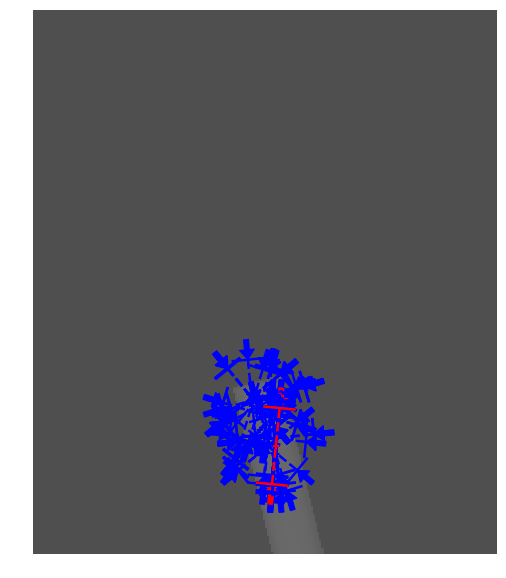

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.1625616469965576, 'left_w1': 1.0155638529419733, 'left_w2': 0.30258248106124286, 'left_e0': -1.103106560198302, 'left_e1': 1.9009163684348143, 'left_s0': -0.4984379237596212, 'left_s1': -0.5213364506730991}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3655267080565343, 'left_w1': 0.813834548634984, 'left_w2': 0.22967848367169325, 'left_e0': -0.8382151078891928, 'left_e1': 1.778518289522882, 'left_s0': -0.6398092062218891, 'left_s1': -0.2895114274093294}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.1175735136421787, 'left_w1': 1.001773066001823, 'left_w2': 0.3299701856931446, 'left_e0': -1.0927137375495986, 'left_e1': 1.8898154

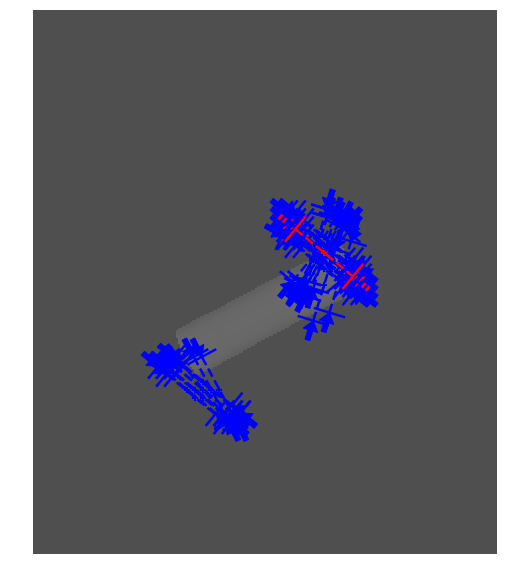

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.2388178322824645, 'left_w1': 0.8510126481220631, 'left_w2': -3.059000015258789, 'left_e0': -0.24547438917619152, 'left_e1': 1.4988843375989782, 'left_s0': -1.0705802582991155, 'left_s1': -0.7496128860362883}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.25972963520366943, 'left_w1': 0.6773853186002884, 'left_w2': -3.059000015258789, 'left_e0': -0.1786676289790152, 'left_e1': 1.3539175094558558, 'left_s0': -1.1176498388188216, 'left_s1': -0.43771986839008065}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.21840721222458373, 'left_w1': 0.8558765231062585, 'left_w2': -3.0447200555809943, 'left_e0': -0.2300693484674798, 'left_e1': 1.

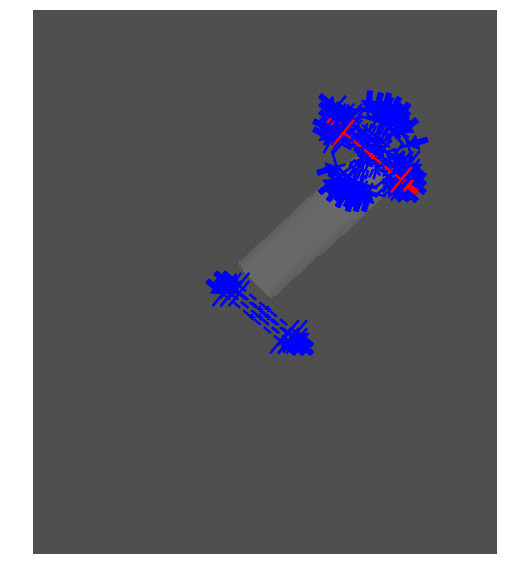

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.30633802055031917, 'left_w1': 1.0235950391427537, 'left_w2': -3.059000015258789, 'left_e0': -0.31518181251857696, 'left_e1': 1.1824594952300747, 'left_s0': -1.056520077744299, 'left_s1': -0.5902748560093664}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.3324542114368742, 'left_w1': 0.8833830514421015, 'left_w2': -3.0564726029086726, 'left_e0': -0.2672943655825017, 'left_e1': 1.0160095361110417, 'left_s0': -1.0935094839682378, 'left_s1': -0.2905426555451962}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.2920585894809371, 'left_w1': 1.0257338216878995, 'left_w2': -3.059000015258789, 'left_e0': -0.30683007730172795, 'left_e1': 1.19

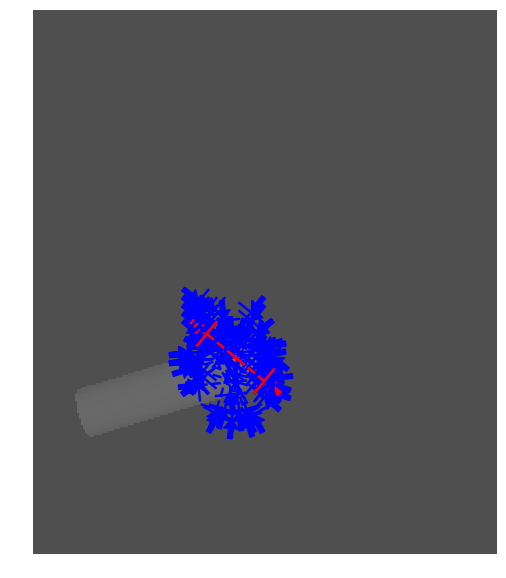

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.24106023609532318, 'left_w1': 0.6805460084075926, 'left_w2': -3.059000015258789, 'left_e0': -0.24232335155480056, 'left_e1': 1.813358062139442, 'left_s0': -1.018827821253321, 'left_s1': -0.8943808225089509}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.2562680329396281, 'left_w1': 0.466719514916169, 'left_w2': -3.059000015258789, 'left_e0': -0.13457407871537191, 'left_e1': 1.6760439818149402, 'left_s0': -1.0973590657473669, 'left_s1': -0.5546888065920513}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.20267373895520172, 'left_w1': 0.6849354524874481, 'left_w2': -3.0264542681918507, 'left_e0': -0.2129179904090279, 'left_e1': 1.815

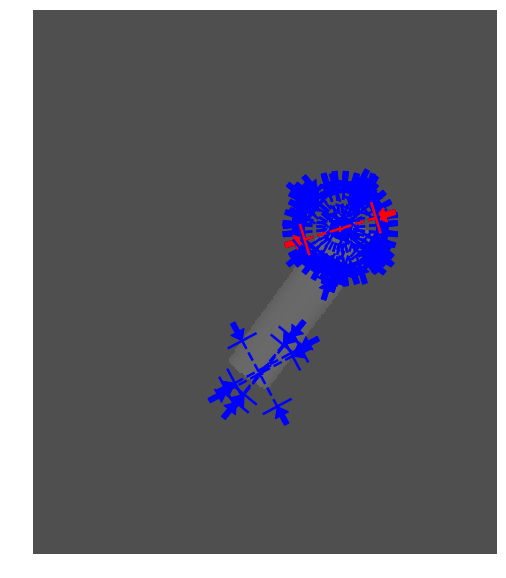

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.329655592371574, 'left_w1': 1.331466368925264, 'left_w2': 1.756838528449212, 'left_e0': -1.284647238618986, 'left_e1': 1.3685883394504503, 'left_s0': -0.5632511697616259, 'left_s1': -0.17647922259358045}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.4413722485589149, 'left_w1': 1.1406477588847919, 'left_w2': 1.784124818879875, 'left_e0': -1.1238816767535613, 'left_e1': 1.2346582618019362, 'left_s0': -0.6357815148917065, 'left_s1': 0.02741965498760686}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3226553885655448, 'left_w1': 1.333196273850812, 'left_w2': 1.7539635317896938, 'left_e0': -1.2836660966883555, 'left_e1': 1.3719430714

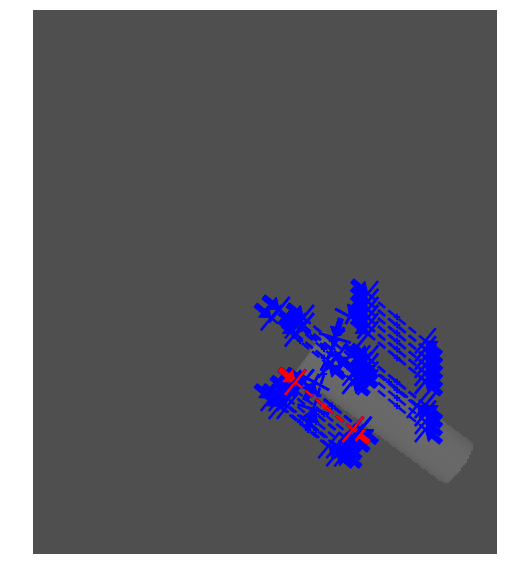

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.10644148513664646, 'left_w1': 0.6566492628249684, 'left_w2': -3.059000015258789, 'left_e0': -0.10687156371553753, 'left_e1': 1.8368792670395828, 'left_s0': -1.2284662318313726, 'left_s1': -0.917233340392311}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.11407802909870918, 'left_w1': 0.4435161128299197, 'left_w2': -3.059000015258789, 'left_e0': -0.057918223951993586, 'left_e1': 1.696949299285147, 'left_s0': -1.2644529858870797, 'left_s1': -0.5663927045040471}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.08992631325476277, 'left_w1': 0.664208102872416, 'left_w2': -3.043488328627778, 'left_e0': -0.09428698743649394, 'left_e1': 1.8

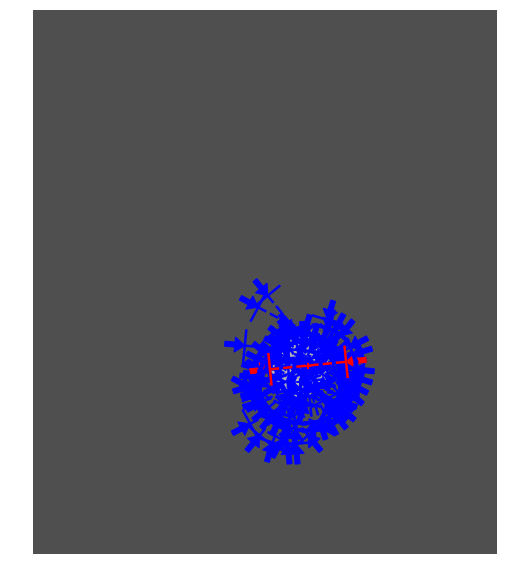

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3328934766128349, 'left_w1': 1.270725279975799, 'left_w2': 1.7606613416458181, 'left_e0': -1.2874443970850862, 'left_e1': 1.6816175329859664, 'left_s0': -0.4669597992740816, 'left_s1': -0.2571756071968667}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.4987521103834063, 'left_w1': 1.0659539430127385, 'left_w2': 1.7515496766115974, 'left_e0': -1.0643395958904802, 'left_e1': 1.5464751251708917, 'left_s0': -0.5624397252246041, 'left_s1': -0.0503607798680699}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.3213939026005466, 'left_w1': 1.2599767937365747, 'left_w2': 1.7616886316416396, 'left_e0': -1.2750707240990273, 'left_e1': 1.666520

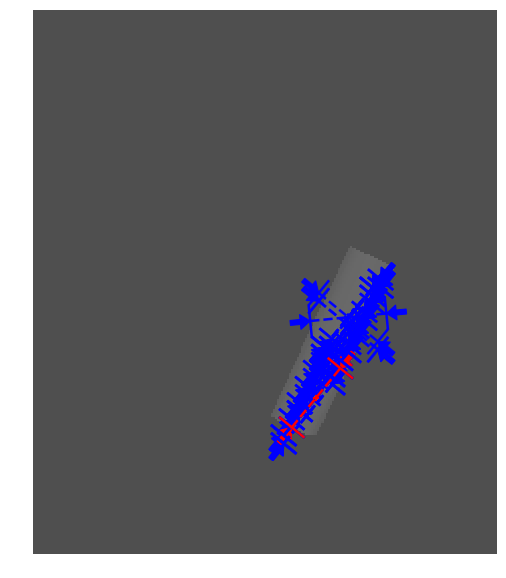

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.2324737643118218, 'left_w1': 1.1433329860032144, 'left_w2': 0.9222238368665392, 'left_e0': -1.182451987192953, 'left_e1': 1.7677239593579588, 'left_s0': -0.5096897224788826, 'left_s1': -0.39113126547896127}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.4071116616990496, 'left_w1': 0.9444098742306459, 'left_w2': 0.8901598548105629, 'left_e0': -0.9474195317402789, 'left_e1': 1.6403016026203545, 'left_s0': -0.6217585969519939, 'left_s1': -0.17227515678501706}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 1.205684406870209, 'left_w1': 1.126075192946054, 'left_w2': 0.9350633781774643, 'left_e0': -1.1695783713078756, 'left_e1': 1.756051

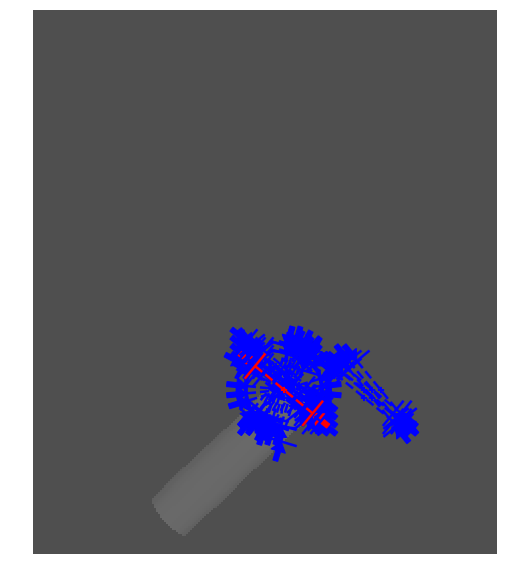

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.16630377570782684, 'left_w1': 0.6618439262080477, 'left_w2': -3.059000015258789, 'left_e0': -0.1669261444659958, 'left_e1': 1.8342626408260891, 'left_s0': -1.1349926497130054, 'left_s1': -0.9118268613544042}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.1761532369569381, 'left_w1': 0.44760384818362503, 'left_w2': -3.059000015258789, 'left_e0': -0.08987726102810831, 'left_e1': 1.6952578643897673, 'left_s0': -1.1915290840932686, 'left_s1': -0.5641872883571034}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.1389800288312477, 'left_w1': 0.6679704559554155, 'left_w2': -3.0355445972415067, 'left_e0': -0.14550561878833768, 'left_e1': 1.

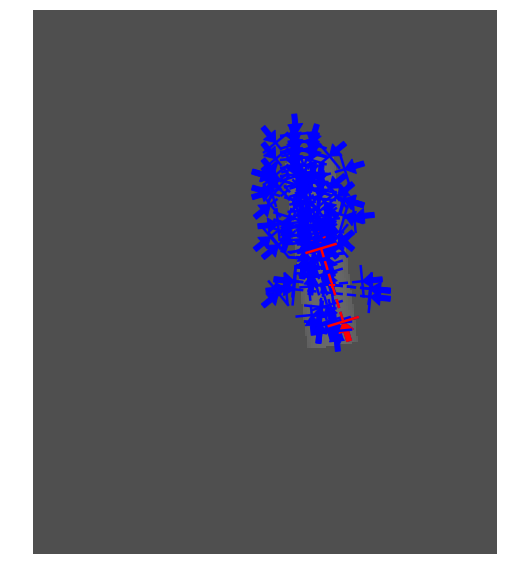

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.5807542055652942, 'left_w1': 0.8907011230529287, 'left_w2': -2.736935355403953, 'left_e0': -0.5863312836014407, 'left_e1': 1.5526041392902266, 'left_s0': -0.8641579558250168, 'left_s1': -0.6922854749152225}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.6787407857020201, 'left_w1': 0.7163428835854478, 'left_w2': -2.7649092961840975, 'left_e0': -0.4649769013070688, 'left_e1': 1.4154680236875878, 'left_s0': -0.9456455475622917, 'left_s1': -0.3977862537542805}
------------------


In [ ]:
method = 'Greedy'
batch_size = 20

for j in range(5):
    rospy.sleep(3.)
    cropped_depth_imgs = np.zeros([batch_size,crop_size*2,crop_size*2,1])
    hand_poses = np.zeros([batch_size,6])
    grasp_results = np.zeros([batch_size,])
    policy, get_action = load_policy(j, wx=wx, wy=wy, method=method)

    for i in range(batch_size):
        pnp.move_to_start(open_gripper=True)
        observation = get_rgbd_image()
        color_data = observation["color"][cy-wy:cy+wy,cx-wx:cx+wx,:]
        depth_data = np.float32(observation["depth"][cy-wy:cy+wy,cx-wx:cx+wx])*0.001

        action = get_action(policy, depth_data, color_data)

        center_px, center_py = action.grasp.center.data
        center_depth = depth_data[center_py,center_px]
        gripper_angle = action.grasp.angle

        center_px = center_px - wx + cx
        center_py = center_py - wy + cy

        depth_camera_info = observation["depth_camera_info"]
        K = np.asarray(depth_camera_info.K).reshape([3,3])

        projected_eef_position = np.asarray([center_px,center_py,1.])
        scaled_eef_position = np.matmul(np.linalg.inv(K),projected_eef_position)
        scaled_eef_position = scaled_eef_position*center_depth
        scaled_eef_position[2] = action.grasp.depth
        eef_position = np.matmul(depth_cam_rotation_matrix[:3,:3],scaled_eef_position) + depth_cam_rotation_matrix[:3,3]

        approaching_axis = np.asarray([0.,0.,-1.])
        gripper_axis = np.asarray([-np.sin(gripper_angle),-np.cos(gripper_angle),0.])

        x_axis = np.cross(gripper_axis, approaching_axis) 
        y_axis = gripper_axis
        z_axis = approaching_axis

        gripper_rotation_mtx = np.identity(4)
        gripper_rotation_mtx[:3,0] = x_axis
        gripper_rotation_mtx[:3,1] = y_axis
        gripper_rotation_mtx[:3,2] = z_axis
        eef_quaternion = tf.transformations.quaternion_from_matrix(gripper_rotation_mtx)

        grasp_pose = geometry_msgs.msg.Pose()
        grasp_pose.position.x = eef_position[0]
        grasp_pose.position.y = eef_position[1]
        grasp_pose.position.z = eef_position[2] - 0.9115
        grasp_pose.orientation.x = eef_quaternion[0]
        grasp_pose.orientation.y = eef_quaternion[1]
        grasp_pose.orientation.z = eef_quaternion[2]
        grasp_pose.orientation.w = eef_quaternion[3]

        if eef_position[2] - 0.02 > 0.755:
            grasp_pose.position.z = 0.757 - 0.9115
            
        pnp.move_to_ready(open_gripper=True)
        pnp.pick(grasp_pose)
        pnp.move_to_ready(open_gripper=False)
        pnp.move_to_start(open_gripper=False)
        
        for k in range(number_of_object):
            grasp_result = get_grasp_result("object"+str(k))
            if grasp_result:
                break

        cropped_depth_imgs[i,:,:,:] = np.float32(observation["depth"][center_py-crop_size:center_py+crop_size,center_px-crop_size:center_px+crop_size,np.newaxis])*0.001        
        hand_poses[i,2] = action.grasp.depth
        hand_poses[i,3] = gripper_angle
        grasp_results[i] = grasp_result

        print("===================================================")
        print("[%d] Total : %d/%d, Current : %d"%(j,np.sum(grasp_results),i+1,grasp_result))
        print("===================================================")
        
        if (i+1)%number_of_object == 0:
            for k in range(number_of_object):
                set_object_state(set_model,"object"+str(k))
            rospy.sleep(3.)

    with open(os.path.join(target_dir+method+"-FC/tensors", fname[0]+'%05d.npz'%j), 'wb') as f_dim:
        np.savez(f_dim, cropped_depth_imgs)

    with open(os.path.join(target_dir+method+"-FC/tensors", fname[1]+'%05d.npz'%j), 'wb') as f_grasp:
        np.savez(f_grasp, hand_poses)

    with open(os.path.join(target_dir+method+"-FC/tensors", fname[2]+'%05d.npz'%j), 'wb') as f_metric:
        np.savez(f_metric, grasp_results)

    train_policy(j, method=method+"-FC")